                    TITLE : Project Model evaluations
 USECASE : ALL TRUMPS TWITTER INSULTS



 GOAL :performed sentimental analysis on trumps twitter data using pretrained and trained embedding for LSTM,BILSTM,BILSTM with attention & gre models.
 tweet generation transformers using transformers(using GPT20
 CONTENTS:


1.   Importing libraries
2.   Text Preprocessing
3.   Exploratory data analysis 
4.   Use case 1:Sentimental analysis  
      (Embedding Models)

    *   Tokenizing and Padding
    *   Defining Custom Function

    *   Training embedding  from Scratch[basic models(lstm,bilstm,bilstm with attention) word2vec model(BILSTM)]
    *   Naives Bayes Classifier
    *   Pretrained embedding  [Glove , word2vec,fasttext] for LSTM,BILSTM,BILSTM with attention,GRU model,BERT

    *   Performance Evaluations and Comparison among all 5 models

    

5.Use case 2 :Tweet generation transformers(using GPT2)















 Submitted by    : Rohini Kolli
 
 Submission Date : 08-15-2022

##Installing required libraries

In [35]:
!pip install scikit-plot


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Libraries

In [39]:
import pandas as pd
import string
import regex as re
import numpy as np
from numpy import asarray
from numpy import zeros
    
#nltk
import nltk
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import tokenize
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer
from nltk.sentiment.util import *
#sci-kit learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import scikitplot as skplt
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, 
                             mean_squared_error, log_loss, precision_recall_curve, classification_report, 
                             precision_recall_fscore_support)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.models.word2vec as w2v
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors


from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from wordcloud import WordCloud

import tensorflow as tf

#KERAS
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Flatten, LSTM, Bidirectional, Input, Layer
from keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.layers.core import Activation, Dropout, Dense
from keras import backend as K
from tensorflow.keras.optimizers import Adam

Importing data set

reading data into dataframe

In [40]:
twitter_df = pd.read_csv('/content/drive/MyDrive/trump_insult_tweets_2014_to_2021.csv')

In [41]:
twitter_df.head(5)

,Unnamed: 0,date,target,insult,tweet
0,1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ..."
1,2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ..."
2,3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...
3,4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...
4,5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily..."


In [42]:
twitter_df.tail(5)

,Unnamed: 0,date,target,insult,tweet
10355,10356,2021-01-06,2020-election,Many States want to decertify the mistake they...,If Vice President @Mike_Pence comes through fo...
10356,10357,2021-01-06,2020-election,"based on irregularities and fraud, plus corrup...","States want to correct their votes, which they..."
10357,10358,2021-01-06,2020-election,Our Election Process is worse than that of thi...,"They just happened to find 50,000 ballots late..."
10358,10359,2021-01-06,2020-election,a FRAUD,The States want to redo their votes. They foun...
10359,10360,2021-01-06,chuck-todd,"Sleepy Eyes, Sad to watch!",Sleepy Eyes Chuck Todd is so happy with the fa...


checking shape

In [43]:
twitter_df.shape

(10360, 5)

Data Cleaning - Removing missing or null values

In [44]:
twitter_df.isnull().sum()

Unnamed: 0    0
date          0
target        2
insult        0
tweet         0
dtype: int64

In [45]:
twitter_df.dropna(inplace=True)
twitter_df.shape

(10358, 5)

In [46]:
# verify
twitter_df.isnull().sum()

Unnamed: 0    0
date          0
target        0
insult        0
tweet         0
dtype: int64

Count of unique topic, people, community, etc. targeted.

In [47]:
twitter_df.target.unique().shape

(866,)

We can observe that out of 10358 targets only 866 are unique. So people, community etc. are targeted multiple times by his tweets

In [48]:
twitter_df.dtypes


Unnamed: 0     int64
date          object
target        object
insult        object
tweet         object
dtype: object

In [49]:
twitter_df['date'] = twitter_df['date'].astype('datetime64[ns]')#changing datatype from object to datetime

In [50]:
twitter_df.dtypes#verifying

Unnamed: 0             int64
date          datetime64[ns]
target                object
insult                object
tweet                 object
dtype: object

In [51]:
twitter_df['Year'] = twitter_df['date'].dt.year

In [52]:
twitter_df.head()

,Unnamed: 0,date,target,insult,tweet,Year
0,1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ...",2014
1,2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ...",2014
2,3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...,2015
3,4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...,2015
4,5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily...",2015


In [53]:
# deleting unnamed column
twitter_df.drop('Unnamed: 0', axis = 1, inplace = True)

In [54]:
twitter_df

,date,target,insult,tweet,Year
0,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ...",2014
1,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ...",2014
2,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...,2015
3,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...,2015
4,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily...",2015
...,...,...,...,...,...
10355,2021-01-06,2020-election,Many States want to decertify the mistake they...,If Vice President @Mike_Pence comes through fo...,2021
10356,2021-01-06,2020-election,"based on irregularities and fraud, plus corrup...","States want to correct their votes, which they...",2021
10357,2021-01-06,2020-election,Our Election Process is worse than that of thi...,"They just happened to find 50,000 ballots late...",2021
10358,2021-01-06,2020-election,a FRAUD,The States want to redo their votes. They foun...,2021


##Pre processing

To prepare the text data for the model building we perform text preprocessing. It is the very first step of NLP projects. Some of the preprocessing steps are:

Removing punctuations like . , ! $( ) * % @

Removing URLs

Removing Stop words

Lower casing

Tokenization

Stemming

Lemmatization

In [55]:
class Text_Processing:
  #Convert to lower case
  def lower_case():
    twitter_df['tweet'] = twitter_df['tweet'].apply(lambda x:x.lower())
  #Remove puntuations
  import regex as re
  def remove_punctuation(data, column):
        '''
        Function : To remove all special characters
        Use: To convert all the alphabets in a column into small letters
        eg. Text_Processing.remove_punctuation(df,'column_name')
        Attributes: data, column
        data: Data Frame
        column: Column name in which operation to be performed
        '''
        data[column].replace(regex=True,inplace=True,to_replace=r'[^0-9a-zA-Z]',value=' ')
  #Stop words removal 
    
  def remove_stopwords(data,column):

      nltk.download('stopwords')
      stop = stopwords.words('english')
      twitter_df['tweet'] = twitter_df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

  #word tokenize
  def split_words():

      twitter_df['tweet_tokenized'] = twitter_df['tweet'].apply(lambda x: x.split())

  #lemmatization
  def word_lemmatize():
      nltk.download('wordnet')
      nltk.download('omw-1.4')
      lemmatizer = WordNetLemmatizer()
      twitter_df['tweet_lemmatized'] = twitter_df['tweet_tokenized'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

  

            
  

Outputs of pre processing are below

Lower casing

In [56]:
Text_Processing.lower_case()

In [57]:
twitter_df['tweet'][:5]

0    can you believe this fool, dr. thomas frieden ...
1    can you believe this fool, dr. thomas frieden ...
2    big time in u.s. today - make america great ag...
3    politician @senatorcardin didn't like that i s...
4    for the nonbeliever, here is a photo of @neily...
Name: tweet, dtype: object

Removing puntuations

In [58]:
Text_Processing.remove_punctuation(twitter_df,'tweet')

In [59]:
twitter_df['tweet'][:5]

0    can you believe this fool  dr  thomas frieden ...
1    can you believe this fool  dr  thomas frieden ...
2    big time in u s  today   make america great ag...
3    politician  senatorcardin didn t like that i s...
4    for the nonbeliever  here is a photo of  neily...
Name: tweet, dtype: object

Stop words removal

In [60]:
Text_Processing.remove_stopwords(twitter_df,'tweet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
twitter_df['tweet'][:5]

0    believe fool dr thomas frieden cdc stated anyo...
1    believe fool dr thomas frieden cdc stated anyo...
2    big time u today make america great politician...
3    politician senatorcardin like said baltimore n...
4    nonbeliever photo neilyoung office request tot...
Name: tweet, dtype: object

Word tokenize

In [62]:
Text_Processing.split_words()

In [63]:
twitter_df['tweet_tokenized'][:5]

0    [believe, fool, dr, thomas, frieden, cdc, stat...
1    [believe, fool, dr, thomas, frieden, cdc, stat...
2    [big, time, u, today, make, america, great, po...
3    [politician, senatorcardin, like, said, baltim...
4    [nonbeliever, photo, neilyoung, office, reques...
Name: tweet_tokenized, dtype: object

Word lemmatize

In [64]:
Text_Processing.word_lemmatize()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [65]:
twitter_df['tweet_lemmatized'].head()

0    [believe, fool, dr, thomas, frieden, cdc, stat...
1    [believe, fool, dr, thomas, frieden, cdc, stat...
2    [big, time, u, today, make, america, great, po...
3    [politician, senatorcardin, like, said, baltim...
4    [nonbeliever, photo, neilyoung, office, reques...
Name: tweet_lemmatized, dtype: object

In [66]:
twitter_df.head()

,date,target,insult,tweet,Year,tweet_tokenized,tweet_lemmatized
0,2014-10-09,thomas-frieden,fool,believe fool dr thomas frieden cdc stated anyo...,2014,"[believe, fool, dr, thomas, frieden, cdc, stat...","[believe, fool, dr, thomas, frieden, cdc, stat..."
1,2014-10-09,thomas-frieden,DOPE,believe fool dr thomas frieden cdc stated anyo...,2014,"[believe, fool, dr, thomas, frieden, cdc, stat...","[believe, fool, dr, thomas, frieden, cdc, stat..."
2,2015-06-16,politicians,all talk and no action,big time u today make america great politician...,2015,"[big, time, u, today, make, america, great, po...","[big, time, u, today, make, america, great, po..."
3,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,politician senatorcardin like said baltimore n...,2015,"[politician, senatorcardin, like, said, baltim...","[politician, senatorcardin, like, said, baltim..."
4,2015-06-24,neil-young,total hypocrite,nonbeliever photo neilyoung office request tot...,2015,"[nonbeliever, photo, neilyoung, office, reques...","[nonbeliever, photo, neilyoung, office, reques..."


Count Hashtags in Tweets

In [ ]:
twitter_df['hash'] = twitter_df['tweet'].apply(lambda word:word.count('#'))

Count Mentions in Tweets¶

In [ ]:
twitter_df['men'] = twitter_df['tweet'].apply(lambda word:word.count('@'))

Media

In [ ]:
twitter_df['med'] = twitter_df['tweet'].apply(lambda word:word.count('https://t.co/'))
twitter_df['med'].unique()

array([0, 1, 2])

Tweet Length Characters & Class

In [ ]:
twitter_df['tweet_length_ch']=twitter_df['tweet'].apply(lambda x:len(x))
twitter_df=twitter_df.loc[twitter_df['tweet_length_ch']<=280]

#=== 
twitter_df['tweet_length']=twitter_df['tweet_length_ch'].apply(lambda x:'short' if x <=130 else 'long')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


EDA

Exploratory data analysis is one of the most important parts of any machine learning workflow and Natural Language Processing is no different

Text statistics visualizations are simple but very insightful techniques. 

They include:

word frequency analysis,

sentence length analysis,

average word length analysis,

word clouds

etc.

Those really help explore the fundamental characteristics of the text data.

Check Tweets Length

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


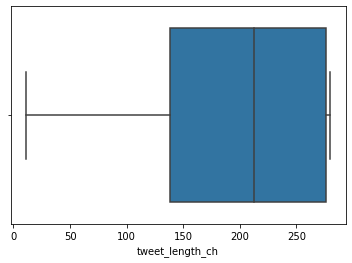

In [ ]:
sns.boxplot(twitter_df['tweet_length_ch'])

From the above box plot we can depict the tweet lengths it varies from min_value = 140 to max_value = 270(appox)

Tweet Length Distribution

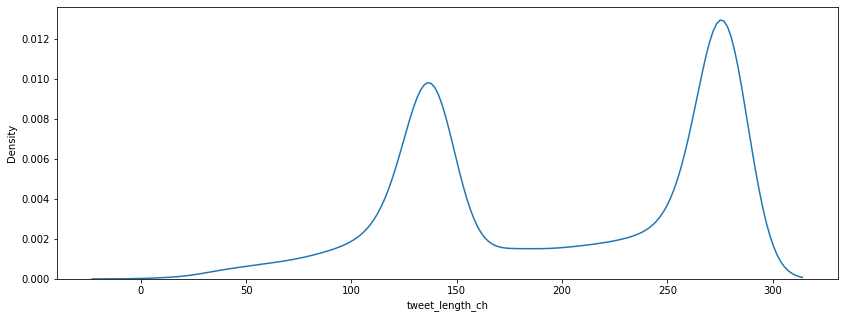

In [ ]:
plt.figure(figsize=(14,5))
twitter = twitter_df['tweet_length_ch']
sns.kdeplot(data=twitter)

From the above graph we can the distribution of tweets wrt density

<Figure size 720x504 with 0 Axes>

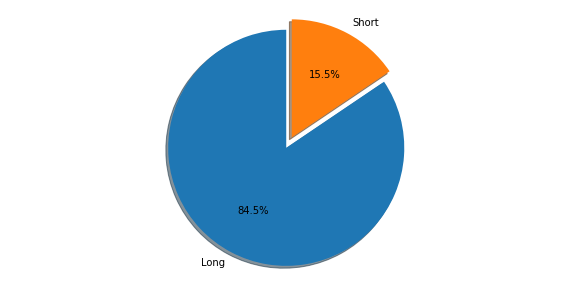

In [ ]:
plt.figure(figsize=(10,7))
labels = 'Long', 'Short'
sizes = [8748,1610]
explode = (0.1, 0)  
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90);
plt.axis('equal'); 

From the above we can see the percentage of long tweets and short tweets(i have given condition in python code based on that visualization is made.

Mentions in Tweet Length

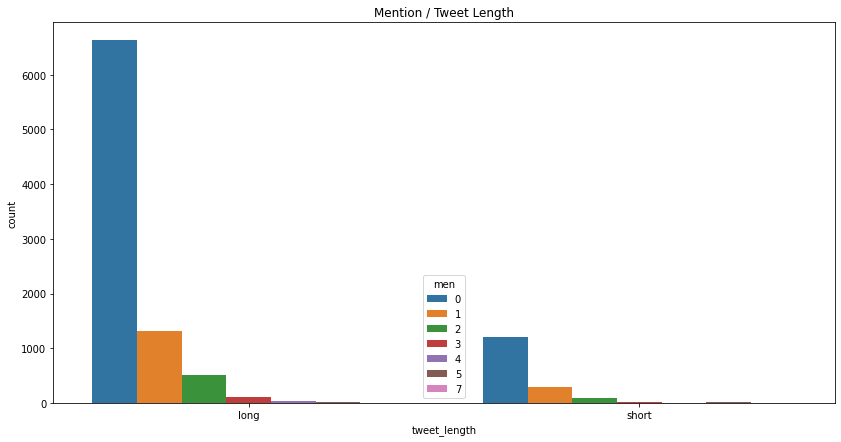

In [ ]:
plt.figure(figsize=(14,7))
sns.countplot(data=twitter_df,x='tweet_length',hue='men').set_title('Mention / Tweet Length');

From above we can see the long and short tweets and top 7 mentions count

In [ ]:
insult_tw=twitter_df.groupby('tweet',as_index=False).agg({'insult':'count'})
insult_tw.describe()

,insult
count,5607.000000
mean,1.821830
std,1.161811
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,16.000000


In [ ]:
insult_tw_75 = insult_tw.loc[insult_tw['insult']==16]
print('Most tweet have insulted Targets is : ',insult_tw_75.values)

Most tweet have insulted Targets is :  [['The Fake News Networks, those that knowingly have a sick and biased AGENDA, are worried about the competition and quality of Sinclair Broadcast. The ‘Fakers’ at CNN, NBC, ABC & CBS have done so much dishonest reporting that they should only be allowed to get awards for fiction!'
  16]]


From the above we can most tweet have insulted target tweet

The Media

Most insult word with The Media was :  Fake News    315
Name: insult, dtype: int64


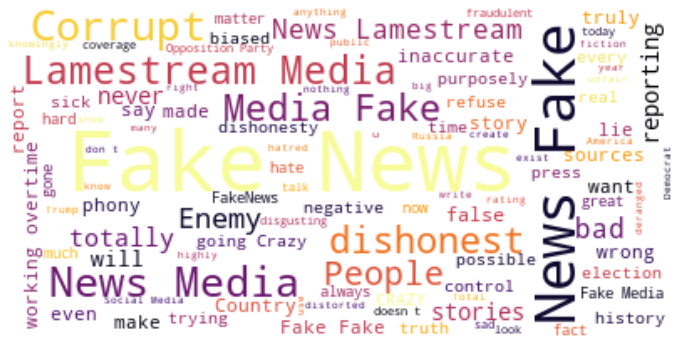

In [ ]:
df_media=twitter_df.loc[twitter_df['target']=='the-media']
print('Most insult word with The Media was : ',df_media['insult'].value_counts()[:1])
#==============
tweet_All = " ".join(insul for insul in df_media.insult)


fig, ax = plt.subplots(1, 1, figsize  = (12,10))

wordcloud_ALL = WordCloud(max_font_size=50, max_words=100,colormap="inferno", background_color="white").generate(tweet_All)

ax.imshow(wordcloud_ALL, interpolation='bilinear')

ax.axis('off');

From above wordcloud we can visualiza words part of trumps target on media and his targeted tweets on them.we can see that trump mostly used media to target  as fake ,negative,lamestreamn media etc

Joe Biden

Most insult word with joe biden was :  Sleepy Joe    125
Name: insult, dtype: int64


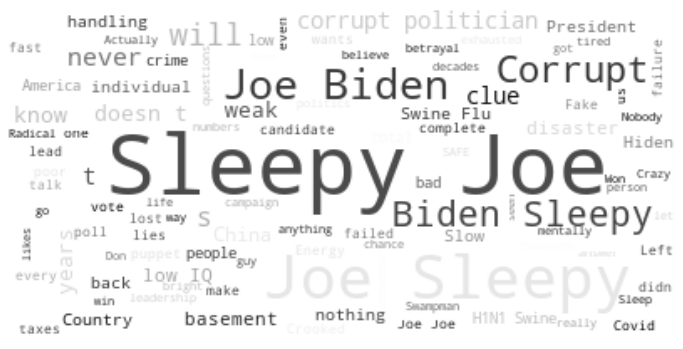

In [ ]:
df_bide=twitter_df.loc[twitter_df['target']=='joe-biden']
print('Most insult word with joe biden was : ',df_bide['insult'].value_counts()[:1])
#==============
tweet_All = " ".join(insul for insul in df_bide.insult)


fig, ax = plt.subplots(1, 1, figsize  = (12,10))

wordcloud_ALL = WordCloud(max_font_size=50, max_words=100,colormap='gray', background_color="white").generate(tweet_All)

ax.imshow(wordcloud_ALL, interpolation='bilinear')

ax.axis('off');

From above wordcloud we can visualiza words part of trumps insults in tweets on joe biden , we could see that he insulted him as sleepy joe,disaster, failed etc

Hillary-Clinton

Most insult word with hillary-clinton was :  Crooked    264
Name: insult, dtype: int64


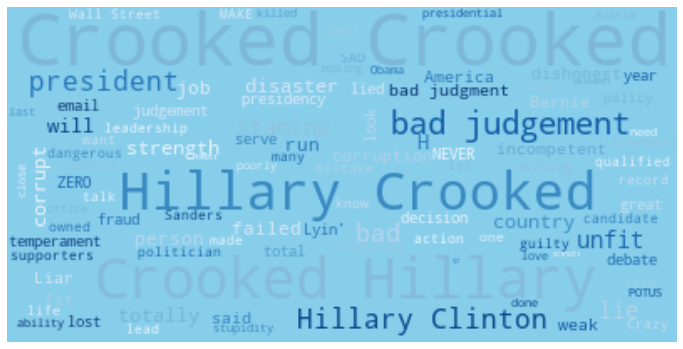

In [ ]:
df_hc=twitter_df.loc[twitter_df['target']=='hillary-clinton']
print('Most insult word with hillary-clinton was : ',df_hc['insult'].value_counts()[:1])
#==============
tweet_All = " ".join(insul for insul in df_hc.insult)


fig, ax = plt.subplots(1, 1, figsize  = (12,10))

wordcloud_ALL = WordCloud(max_font_size=50, max_words=100,colormap="Blues", background_color="skyblue").generate(tweet_All)

ax.imshow(wordcloud_ALL, interpolation='bilinear')

ax.axis('off');

From above wordcloud we can visualiza words part of trumps insults in tweets on hillary , we could see that he insulted her as crooked,bad, nothing credibility etc

Russia-Trump

Most insult word with df_trump_russia was :  Witch Hunt    56
Name: insult, dtype: int64


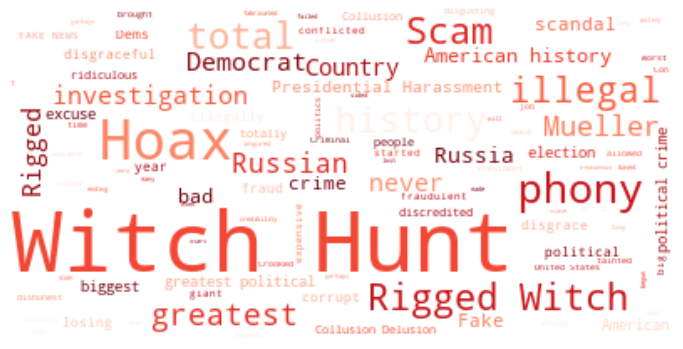

In [ ]:
df_trump_russia =twitter_df.loc[twitter_df['target']=='trump-russia']
print('Most insult word with df_trump_russia was : ',df_trump_russia['insult'].value_counts()[:1])
#==============

tweet_All = " ".join(insul for insul in df_trump_russia.insult)

fig, ax = plt.subplots(1, 1, figsize  = (12,10))
wordcloud_ALL = WordCloud(max_font_size=50,colormap="Reds", max_words=100, background_color="white").generate(tweet_All)

ax.imshow(wordcloud_ALL, interpolation='bilinear')

ax.axis('off');

From above we could see how trump insulted russia as witch hunt,hoax, scam,disgraceful etc

Media in tweets

In [ ]:
plt.figure(figsize=(14,7))
No_Media= len(twitter_df[twitter_df['med']==0])
Media = len(twitter_df[twitter_df['med']>0])
Platform = ['NoMedia','Media']
Count = [No_Media,Media]
#====
fig = px.pie(names = Platform,
             values = Count,
             title='Media/No Media',
            color_discrete_sequence = px.colors.sequential.Agsunset)
fig.update_traces(textposition='inside', textinfo='percent+label')

<Figure size 1008x504 with 0 Axes>

3D Length-Hashtag-Mentions

X = Hashtag , Y = Mention , Z = Tweet Length

In [ ]:
d3 = twitter_df[['tweet_length_ch','men','hash','tweet_length']]
hashtag=twitter_df['hash'].values
mention=twitter_df['men'].values
length=twitter_df['tweet_length_ch'].values
L= twitter_df['tweet_length'].values
trace = go.Scatter3d(x=hashtag,y=mention,z=length,mode='markers',marker=dict(size=5,color="crimson"))
fig=go.Figure(data=[trace])
fig.show()

3D represenation of trumps tweet length , mentions,hashtags etc

Top 10 Targets

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



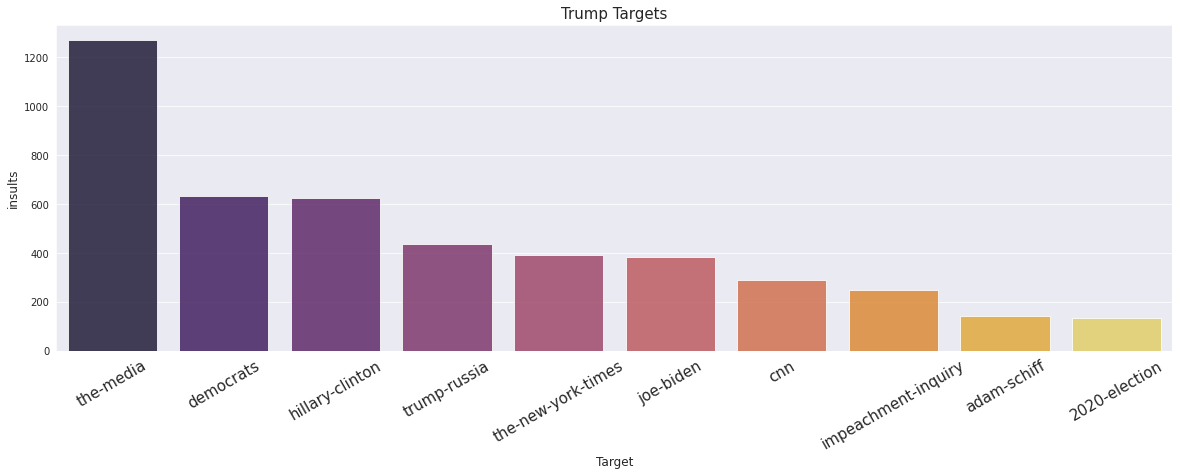

In [ ]:
r_op =twitter_df['target'].value_counts()
r_op = r_op[:10]
sns.set_style("darkgrid")
plt.figure(figsize=(20,6));
r_op_vis = sns.barplot(r_op.index, r_op.values, alpha=0.8,palette="inferno");
plt.title('Trump Targets',fontsize=15);
plt.ylabel('insults', fontsize=12);
plt.xlabel('Target', fontsize=12);
r_op_vis.set_xticklabels(rotation=30,labels=r_op.index,fontsize=15);
plt.show();

The above depicts top 10 targets of trump through his tweets media is his first target.

Most Target People by year

In [ ]:
from IPython.core.display import HTML
HTML('''<div class="flourish-embed flourish-chart" data-src="visualisation/5060515"><script src="https://public.flourish.studio/resources/embed.js"></script></div>''')

From the above flourish  chart we can see trumps targets by each year, we could see after 2018 trumps target has been shifted towards biden from hillary clinton.

Most insults appears

(-0.5, 399.5, 199.5, -0.5)

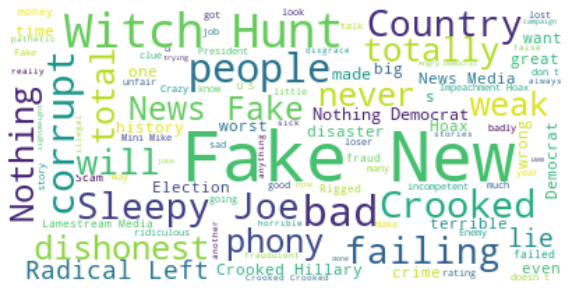

In [ ]:
tweet_All = " ".join(insul for insul in twitter_df.insult)


fig, ax = plt.subplots(1, 1, figsize  = (10,10))

wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)

ax.imshow(wordcloud_ALL, interpolation='bilinear')

ax.axis('off')

From the above word cloud we can  the apperances of most insults we could see fake news , sleepy joe, witch hunt,crooked, dishonest,failing etc 

Insult by year

In [ ]:
from datetime import date
twitter_df['date']=pd.to_datetime(twitter_df['date'])
#====
L = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']
twitter_df = twitter_df.join(pd.concat((getattr(twitter_df['date'].dt, i).rename(i) for i in L), axis=1))
twitter_df['year'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



2020    2603
2019    2412
2018    1757
2016    1539
2017    1118
2015     757
2021      27
2014       2
Name: year, dtype: int64

In [ ]:
dftime = twitter_df.groupby('year',as_index=False).agg({'insult':'count'}).reset_index()
px.line(x=dftime['year'],y=dftime['insult'],title='insult by year')

from above graph we can visualize insult by year , it was in peak stage in 2010, fell down drastically over an year by 2021

Insult by days of week

In [ ]:
dftime_dw = twitter_df.groupby('dayofweek',as_index=False).agg({'insult':'count'}).reset_index()
px.line(x=dftime_dw['dayofweek'],y=dftime_dw['insult'],title='insult by Daysofweek')

Conclusion : This EDA  report is about Trumps twitter insults from 2016-2021,who are targetted, what major insults trump had on leaders, his top mentioned insults etc.may hidden patterns have been identified from this EDA like through years how target has been shifted from hillary to joe biden etc.

NLP Related EDA

Creating a dictionary:

Dictionary include all the word that have been used in the twitter dataset. The Frequency of each word is also identify which tell how many time a particular word is repeated.

In [ ]:
#Creating a dictionary
dictionary=twitter_df['tweet_lemmatized'].tolist()
print('The length of the dictionary is',len(dictionary))

subword_dictionary=[item for sublist in dictionary for item in sublist]
print('The length of the subword dictionary is',len(subword_dictionary))

The length of the dictionary is 10358
The length of the subword dictionary is 201251


Top 10 words and their frequency


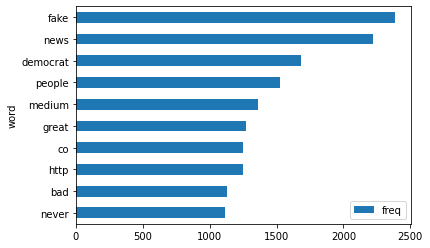

In [ ]:
#Word Frequency
word_counter = Counter(subword_dictionary)

#Plotting top 10 most repeated words
Top_10_common_words = word_counter.most_common()[:10]
Top_10_common_words = pd.DataFrame(Top_10_common_words)
Top_10_common_words.columns = ['word', 'freq']
print('Top 10 words and their frequency')
Top_10_common_words.sort_values(by='freq',ascending=True).plot(x='word', kind='barh')
plt.show()

## Sentimental Analysis

Sentiment analysis is analytical technique that uses statistics, natural language processing, and machine learning to determine the emotional meaning of communications

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. 

It is used for sentiment analysis of text which has both the polarities i.e. positive/negative. VADER is used to quantify how much of positive or negative emotion the text has and also the intensity of emotion.

In [67]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Here, SentimentIntensityAnalyzer() is an object,hich will  give us scores of the following categories:
Positive
Negative

In [68]:

#Adding labels to the data using vaderSentiment
sentiment_model = SentimentIntensityAnalyzer()

twitter_df['n_score'] = [sentiment_model.polarity_scores(x)['neg'] for x in twitter_df['tweet']]

twitter_df.loc[twitter_df['n_score'] > 0.1, 'Sentiments'] = 'neg'
twitter_df.loc[twitter_df['n_score'] <= 0.1, 'Sentiments'] = 'pos'

twitter_df.Sentiments.value_counts()

neg    8737
pos    1621
Name: Sentiments, dtype: int64

In [74]:
twitter_df.tail()

,date,target,insult,tweet,Year,tweet_tokenized,tweet_lemmatized,n_score,Sentiments
10355,2021-01-06,2020-election,Many States want to decertify the mistake they...,vice president mike pence comes us win preside...,2021,"[vice, president, mike, pence, comes, us, win,...","[vice, president, mike, penny, come, u, win, p...",0.158,neg
10356,2021-01-06,2020-election,"based on irregularities and fraud, plus corrup...",states want correct votes know based irregular...,2021,"[states, want, correct, votes, know, based, ir...","[state, want, correct, vote, know, based, irre...",0.183,neg
10357,2021-01-06,2020-election,Our Election Process is worse than that of thi...,happened find 50 000 ballots late last night u...,2021,"[happened, find, 50, 000, ballots, late, last,...","[happened, find, 50, 000, ballot, late, last, ...",0.386,neg
10358,2021-01-06,2020-election,a FRAUD,states want redo votes found voted fraud legis...,2021,"[states, want, redo, votes, found, voted, frau...","[state, want, redo, vote, found, voted, fraud,...",0.487,neg
10359,2021-01-06,chuck-todd,"Sleepy Eyes, Sad to watch!",sleepy eyes chuck todd happy fake voter tabula...,2021,"[sleepy, eyes, chuck, todd, happy, fake, voter...","[sleepy, eye, chuck, todd, happy, fake, voter,...",0.272,neg


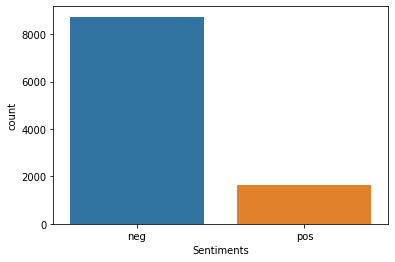

In [ ]:
sns.countplot(x='Sentiments', data=twitter_df)

Transformation

 label encoding in Python, we replace the categorical value with a numeric value
 If the categorical variable value contains 2 distinct classes, we use (0,1)

In [ ]:
twitter_df['Tweet_lemmatized_train'] = twitter_df.tweet_lemmatized.apply(lambda x: ' '.join(x))

x = (twitter_df['Tweet_lemmatized_train']).values.tolist()
y = (twitter_df['Sentiments']).values.tolist()

#Label Encoding Target Variable:
le = preprocessing.LabelEncoder()
le.fit(y)

LabelEncoder()

In [ ]:
list(le.classes_)

['neg', 'pos']

In [ ]:
y = le.transform(y)
print('Labels for \'{}\' are \'{}\' respectively.'.format(le.inverse_transform(np.unique(y)),np.unique(y)))

Labels for '['neg' 'pos']' are '[0 1]' respectively.


here sentiments are classified as positive or negative which are categorical through label encoding we have  converted them to '0' & '1'

**Building bag of Words using CountVectorizer**

The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). our words are transformed to vectors

In [ ]:
bow = CountVectorizer(max_features=25000, lowercase=True,analyzer = "word")
train_bow_neg = bow.fit_transform(x)
train_bow_neg
print('Size of neg bag of words',train_bow_neg.toarray().shape)
train_bow_neg.toarray()[1:5]

Size of neg bag of words (10358, 8989)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
vocab = bow.get_feature_names()
# Sum up the counts of each vocabulary word
dist = np.sum(train_bow_neg.toarray(), axis=0)

wfh = pd.DataFrame({'word':vocab,'freq':dist})
wfh.sort_values(by='freq',ascending=False)[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,word,freq
3015,fake,2384
5412,news,2224
2231,democrat,1681
5852,people,1525
5053,medium,1359
3567,great,1272
1610,co,1247
3892,http,1247
843,bad,1130
5401,never,1115


Embedding Models

Tokenizing and Padding

let's perform the tokenization, sequence encoding, and sequence padding.

Here's what's happening chunk by chunk:
# Tokenize our training data
This is straightforward; we are using the TensorFlow (Keras) Tokenizer class to automate the tokenization of our training data. First we create the Tokenizer object, providing the maximum number of words to keep in our vocabulary after tokenization, as well as an out of vocabulary token to use for encoding test data words we have not come across in our training, without which these previously-unseen words would simply be dropped from our vocabulary and mysteriously unaccounted for. To learn more about other arguments for the TensorFlow tokenizer, check out the documentation. After the Tokenizer has been created, we then fit it on the training data (we will use it later to fit the testing data as well).

# Get our training data word index
A byproduct of the tokenization process is the creation of a word index, which maps words in our vocabulary to their numeric representation, a mapping which will be essential for encoding our sequences. Since we will reference this later to print out, we assign it a variable here to simplify a bit.

# Encode training data sentences into sequences
Now that we have tokenized our data and have a word to numeric representation mapping of our vocabulary, let's use it to encode our sequences. Here, we are converting our text sentences from something like "My name is Matthew," to something like "6 8 2 19," where each of those numbers match up in the index to the corresponding words. Since neural networks work by performing computation on numbers, passing in a bunch of words won't work. Hence, sequences. And remember

 #Get max training sequence length
Remember when we said we needed to have a maximum sequence length for padding our encoded sentences? We could set this limit ourselves, but in our case we will simply find the longest encoded sequence and use that as our maximum sequence length. There would certainly be reasons you would not want to do this in practice, but there would also be times it would be appropriate. The maxlen variable is then used below in the actual training sequence padding.

# Pad the training sequences
As mentioned above, we need our encoded sequences to be of the same length. We just found out the length of the longest sequence, and will use that to pad all other sequences with extra '0's at the end ('post') and will also truncate any sequences longer than maximum length from the end ('post') as well. Here we use the TensorFlow (Keras) pad_sequences module to accomplish this. You can look at the documentation for additional padding options.




In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
maxlen=100
#using keras tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [ ]:
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8551

Defining Custom Functions

Class for BiLSTM with Attention Layer

In [ ]:
class attention(Layer):
    def __init__(self, return_sequences=True):
      self.return_sequences = return_sequences
      super(attention,self).__init__()

    def build(self, input_shape):
      self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                             initializer="normal")
      self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                             initializer="normal")
      
    def call(self, x):
      e = K.tanh(K.dot(x,self.W)+self.b)
      a = K.softmax(e, axis=1)
      output = x*a
      if self.return_sequences:
        
        return output
        
      return K.sum(output, axis=1)

Defining Performance Plot

In [ ]:
def show_performance_plot(history):
  #show the model accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  #show model loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

#Trained models

Training the model from scratch

LSTM without any Pretrained data


Long short term memory networks, usually called LSTM – are a special kind of RNN. They were introduced to avoid the long-term dependency problem. In regular RNN, the problem frequently occurs when connecting previous information to new information.

Running the model

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [ ]:
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=True)#Embedding layer
TrainmodelLSTM = Sequential()
TrainmodelLSTM.add(embedding_layer)
TrainmodelLSTM.add(LSTM(128, return_sequences=True))#Adding lstm layer
TrainmodelLSTM.add(Flatten())
TrainmodelLSTM.add(Dropout(0.5))# Dropout for regularization:
TrainmodelLSTM.add(Dense(1, activation='sigmoid'))#Fully connected layer


TrainmodelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])#compile model
print(TrainmodelLSTM.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          855100    
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          117248    
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_1 (Dropout)         (None, 12800)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 12801     
                                                                 
Total params: 985,149
Trainable params: 985,149
Non-trainable params: 0
_________________________________________________________________
None


The model is compiled with binary cross-entropy loss and adam optimizer. Since we have a binary classification problem, binary cross-entropy loss is used. The Adam optimizer uses stochastic gradient descent to train deep learning models, and it compares each of the predicted probabilities to the actual class label (0 or 1). Accuracy is used as the primary performance metric. The model summary can be seen above

**Model Training and Evaluation**

The model is trained for 10 epochs

The model is evaluated by calculating its accuracy. Accuracy of classification is calculated by dividing the number of correct predictions by the total number of predictions.

In [ ]:
historyTrainmodelLSTM = TrainmodelLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestTrainmodelLSTMM= TrainmodelLSTM.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 29s 503ms/step - loss: 0.4450 - acc: 0.8393 - val_loss: 0.3999 - val_acc: 0.8323
Epoch 2/10
52/52 [==============================] - 30s 568ms/step - loss: 0.2381 - acc: 0.9003 - val_loss: 0.2224 - val_acc: 0.9107
Epoch 3/10
52/52 [==============================] - 25s 472ms/step - loss: 0.0842 - acc: 0.9691 - val_loss: 0.2469 - val_acc: 0.9252
Epoch 4/10
52/52 [==============================] - 22s 417ms/step - loss: 0.0388 - acc: 0.9875 - val_loss: 0.3555 - val_acc: 0.9391
Epoch 5/10
52/52 [==============================] - 22s 422ms/step - loss: 0.0191 - acc: 0.9943 - val_loss: 0.4918 - val_acc: 0.9312
Epoch 6/10
52/52 [==============================] - 23s 439ms/step - loss: 0.0129 - acc: 0.9964 - val_loss: 0.3545 - val_acc: 0.9385
Epoch 7/10
52/52 [==============================] - 23s 449ms/step - loss: 0.0090 - acc: 0.9973 - val_loss: 0.6516 - val_acc: 0.9294
Epoch 8/10
52/52 [==============================] - 22s 419ms/step - 

In [ ]:
y_pred = (TrainmodelLSTM.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.9165057915057915
65/65 [==============================] - 2s 36ms/step - loss: 0.6982 - acc: 0.9165
[0.6981731057167053, 0.9165058135986328]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1764
           1       0.72      0.72      0.72       308

    accuracy                           0.92      2072
   macro avg       0.83      0.84      0.84      2072
weighted avg       0.92      0.92      0.92      2072



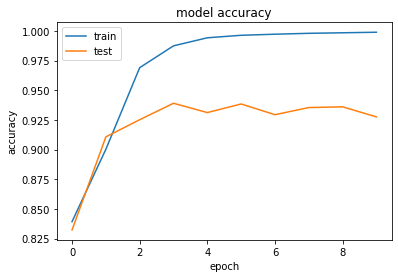

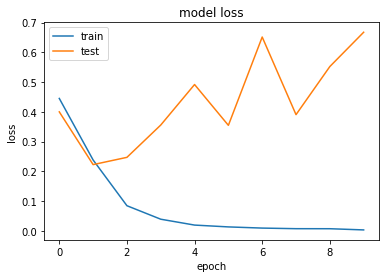

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(TrainmodelLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyTrainmodelLSTM)

From the above LSTM basic model we have observed accuracy of 91% and the classification report is generated and plot shows us the model Accuracy and model loss of the  basic LSTM model

BiLSTM without any pretrained data

Bidirectional long-short term memory(bi-lstm) is the process of making any neural network o have the sequence information in both directions backwards (future to past) or forward(past to future). 

In bidirectional, our input flows in two directions, making a bi-lstm different from the regular LSTM. With the regular LSTM, we can make input flow in one direction, either backwards or forward. However, in bi-directional, we can make the input flow in both directions to preserve the future and the past information.

In [ ]:
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=True)#creating embedding layer
TrainmodelBiLSTM = Sequential()
TrainmodelBiLSTM.add(embedding_layer)# adding embedding layer
TrainmodelBiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
TrainmodelBiLSTM.add(Flatten())
TrainmodelBiLSTM.add(Dropout(0.5))
TrainmodelBiLSTM.add(Dense(1, activation='sigmoid'))


TrainmodelBiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])#compiling BIlstm model
print(TrainmodelBiLSTM.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          855100    
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         234496    
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_2 (Dropout)         (None, 25600)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 25601     
                                                                 
Total params: 1,115,197
Trainable params: 1,115,197
Non-trainable params: 0
____________________________________________

The model is compiled with binary cross-entropy loss and adam optimizer. Since we have a binary classification problem, 
binary cross-entropy loss is used. The Adam optimizer uses stochastic gradient descent to train deep learning models, 
and it compares each of the predicted probabilities to the actual class label (0 or 1).
 Accuracy is used as the primary performance metric. The model summary can be seen above


**Model evaluation**

The model is trained for 10 epochs


In [ ]:
historyTrainmodelBiLSTM = TrainmodelBiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestTrainmodelBiLSTMM= TrainmodelBiLSTM.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 47s 801ms/step - loss: 0.4383 - acc: 0.8372 - val_loss: 0.3490 - val_acc: 0.8378
Epoch 2/10
52/52 [==============================] - 40s 775ms/step - loss: 0.2138 - acc: 0.9120 - val_loss: 0.2189 - val_acc: 0.9180
Epoch 3/10
52/52 [==============================] - 40s 779ms/step - loss: 0.0837 - acc: 0.9704 - val_loss: 0.2710 - val_acc: 0.9312
Epoch 4/10
52/52 [==============================] - 41s 778ms/step - loss: 0.0402 - acc: 0.9872 - val_loss: 0.2939 - val_acc: 0.9324
Epoch 5/10
52/52 [==============================] - 41s 779ms/step - loss: 0.0160 - acc: 0.9953 - val_loss: 0.4303 - val_acc: 0.9343
Epoch 6/10
52/52 [==============================] - 41s 781ms/step - loss: 0.0091 - acc: 0.9974 - val_loss: 0.4166 - val_acc: 0.9343
Epoch 7/10
52/52 [==============================] - 41s 787ms/step - loss: 0.0066 - acc: 0.9983 - val_loss: 0.4542 - val_acc: 0.9312
Epoch 8/10
52/52 [==============================] - 41s 790ms/step - 

In [ ]:
y_pred = (TrainmodelBiLSTM.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.9247104247104247
65/65 [==============================] - 4s 57ms/step - loss: 0.3800 - acc: 0.9247
[0.3800342381000519, 0.9247104525566101]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1764
           1       0.75      0.74      0.74       308

    accuracy                           0.92      2072
   macro avg       0.85      0.85      0.85      2072
weighted avg       0.92      0.92      0.92      2072



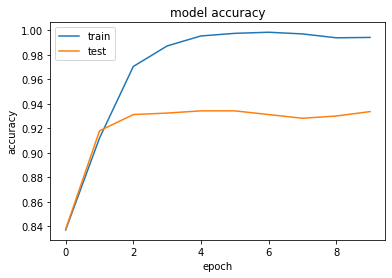

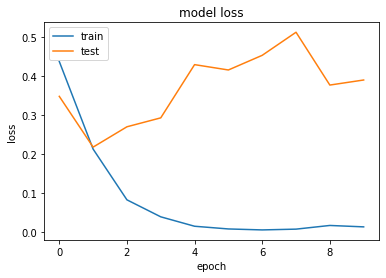

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(TrainmodelBiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyTrainmodelBiLSTM)

From the above BiLSTM basic model we have observed accuracy of 92% and the classification report is generated and plot shows us the model Accuracy and model loss of the basic BiLSTM model

BiLSTM with attention without any Pretrained Data

Before the introduction of the attention mechanism the basic LSTM or RNN model was based on an encoder-decoder system. Where encoding  is used to process the data for encoding it into a context vector and creates a good summary of the input data. Then this summary goes through the decoding part where in decoding the model understands the data and translates the data.

In [ ]:
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=True)
TrainmodelABiLSTM = Sequential()
TrainmodelABiLSTM.add(embedding_layer)
TrainmodelABiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
TrainmodelABiLSTM.add(attention(return_sequences=True))
TrainmodelABiLSTM.add(Flatten())
TrainmodelABiLSTM.add(Dropout(0.5))
TrainmodelABiLSTM.add(Dense(1, activation='sigmoid'))


TrainmodelABiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(TrainmodelABiLSTM.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          855100    
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         234496    
 nal)                                                            
                                                                 
 attention (attention)       (None, 100, 256)          356       
                                                                 
 flatten_3 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25600)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25601     
                                                      

The model is compiled with binary cross-entropy loss and adam optimizer. Since we have a binary classification problem, 
binary cross-entropy loss is used. The Adam optimizer uses stochastic gradient descent to train deep learning models, 
and it compares each of the predicted probabilities to the actual class label (0 or 1).
 Accuracy is used as the primary performance metric. The model summary can be seen above

**Training and evaluating model**

The model is trained for 10 epochs


In [ ]:
historyTrainmodelABiLSTM = TrainmodelABiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestTrainmodelABiLSTMM= TrainmodelABiLSTM.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 55s 842ms/step - loss: 0.4912 - acc: 0.8380 - val_loss: 0.4534 - val_acc: 0.8323
Epoch 2/10
52/52 [==============================] - 41s 786ms/step - loss: 0.3785 - acc: 0.8438 - val_loss: 0.3741 - val_acc: 0.8323
Epoch 3/10
52/52 [==============================] - 41s 788ms/step - loss: 0.2547 - acc: 0.8912 - val_loss: 0.3599 - val_acc: 0.8854
Epoch 4/10
52/52 [==============================] - 41s 797ms/step - loss: 0.3017 - acc: 0.8847 - val_loss: 0.3792 - val_acc: 0.8323
Epoch 5/10
52/52 [==============================] - 41s 793ms/step - loss: 0.2670 - acc: 0.8713 - val_loss: 0.3139 - val_acc: 0.8824
Epoch 6/10
52/52 [==============================] - 41s 790ms/step - loss: 0.1549 - acc: 0.9522 - val_loss: 0.3487 - val_acc: 0.8854
Epoch 7/10
52/52 [==============================] - 41s 791ms/step - loss: 0.1010 - acc: 0.9713 - val_loss: 0.3533 - val_acc: 0.8975
Epoch 8/10
52/52 [==============================] - 41s 784ms/step - 

In [ ]:
y_pred = (TrainmodelABiLSTM.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.9107142857142857
65/65 [==============================] - 4s 56ms/step - loss: 0.3789 - acc: 0.9107
[0.3789480924606323, 0.9107142686843872]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1764
           1       0.74      0.62      0.67       308

    accuracy                           0.91      2072
   macro avg       0.84      0.79      0.81      2072
weighted avg       0.91      0.91      0.91      2072



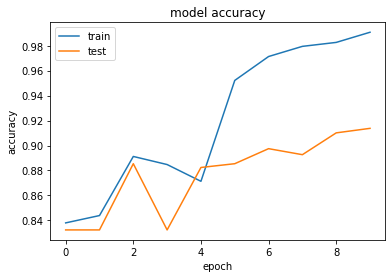

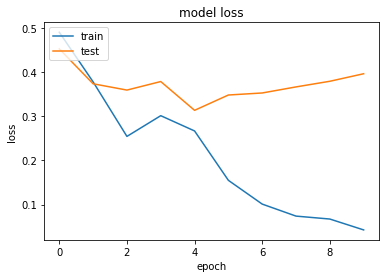

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(TrainmodelABiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyTrainmodelABiLSTM)

The model is evaluated by calculating its accuracy.
 Accuracy of classification is calculated by dividing the number of correct predictions by the total number of predictions.
 From the above classification report we can see that for Bilstm with attention we have a accuracy of 91% .
 From the plots we can depict the model accuracy and model loss

Word2Vec from Scratch

 The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence.

In [ ]:
## train Word2Vec from scratch
#Train Word2Vec model with gensim on the dataset
w2v_model = w2v.Word2Vec(twitter_df.tweet_lemmatized, window=10, min_count=2, workers=5, sample = 0.001)

In [ ]:
# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors
w2v_vocab_size, w2v_embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(w2v_vocab_size, w2v_embedding_size))

Vocabulary Size: 6847 - Embedding Dim: 100


Training and Running the Model

In [ ]:
#Training the model with trained word2vec weights
w2vembedding_layer = Embedding(vocab_size, 100, weights=[w2v_weights], input_length=maxlen , trainable=False)
w2vmodelABiLSTM = Sequential()
w2vmodelABiLSTM.add(embedding_layer)
w2vmodelABiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
w2vmodelABiLSTM.add(attention(return_sequences=True))
w2vmodelABiLSTM.add(Flatten())
w2vmodelABiLSTM.add(Dropout(0.5))
w2vmodelABiLSTM.add(Dense(1, activation='sigmoid'))


w2vmodelABiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(w2vmodelABiLSTM.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          855100    
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 256)         234496    
 nal)                                                            
                                                                 
 attention_1 (attention)     (None, 100, 256)          356       
                                                                 
 flatten_4 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_4 (Dropout)         (None, 25600)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 25601     
                                                      

In [ ]:

historyw2vmodelABiLSTM = w2vmodelABiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestw2vmodelABiLSTM= w2vmodelABiLSTM.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 46s 805ms/step - loss: 0.3608 - acc: 0.8693 - val_loss: 0.3425 - val_acc: 0.8800
Epoch 2/10
52/52 [==============================] - 41s 784ms/step - loss: 0.0915 - acc: 0.9748 - val_loss: 0.3880 - val_acc: 0.8938
Epoch 3/10
52/52 [==============================] - 41s 783ms/step - loss: 0.0546 - acc: 0.9884 - val_loss: 0.3828 - val_acc: 0.9077
Epoch 4/10
52/52 [==============================] - 41s 785ms/step - loss: 0.0363 - acc: 0.9926 - val_loss: 0.4037 - val_acc: 0.9131
Epoch 5/10
52/52 [==============================] - 41s 789ms/step - loss: 0.0286 - acc: 0.9941 - val_loss: 0.4175 - val_acc: 0.9144
Epoch 6/10
52/52 [==============================] - 41s 786ms/step - loss: 0.0345 - acc: 0.9911 - val_loss: 0.3124 - val_acc: 0.9168
Epoch 7/10
52/52 [==============================] - 41s 779ms/step - loss: 0.0341 - acc: 0.9920 - val_loss: 0.4376 - val_acc: 0.9162
Epoch 8/10
52/52 [==============================] - 41s 784ms/step - 

In [ ]:
print("Test Score:", scoreTestw2vmodelABiLSTM[0])
print("Test Accuracy:", scoreTestw2vmodelABiLSTM[1], '\n')

Test Score: 0.4964491128921509
Test Accuracy: 0.91361004114151 



In [ ]:
#Defining class for color
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Word2vec Trained model BiLSTM with Attention Layer


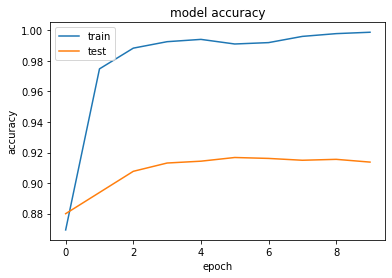

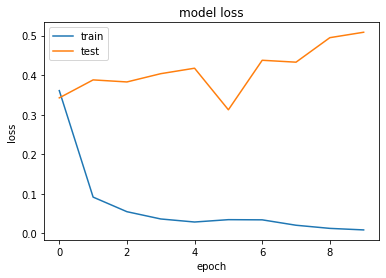

In [ ]:
print(color.BOLD + 'Word2vec Trained model BiLSTM with Attention Layer' + color.END)
show_performance_plot(historyw2vmodelABiLSTM)


Naives Bayes Classification

In [ ]:
#Splitting the data into test and train 
xtrain, xtest, ytrain, ytest = train_test_split \
                (train_bow_neg.toarray(), y,test_size=0.3, \
                random_state=1000)

In [ ]:
print ("No. of True Cases in training data set for" , ytrain.sum())
print ("No. of True Cases in testing data set for",ytest.sum())

print ("Ratio of True Cases in training data set: " , round(ytrain.sum()/len(ytrain),2))
print ("Ratio of True Cases in testing data set: ", round(ytest.sum()/len(ytest),2))

No. of True Cases in training data set for 1127
No. of True Cases in testing data set for 494
Ratio of True Cases in training data set:  0.16
Ratio of True Cases in testing data set:  0.16


In [ ]:
xtrain.shape

(7250, 8989)

In [ ]:
train_bow_neg

<10358x8989 sparse matrix of type '<class 'numpy.int64'>'
	with 190041 stored elements in Compressed Sparse Row format>

In [ ]:
NB = MultinomialNB()
NB_clf = NB.fit( xtrain, ytrain )

In [ ]:
prob_test  = NB.predict_proba(xtest)
prob_train = NB.predict_proba(xtrain)

#Probability Threshold = 0.5 (default) 
pred_test  = NB.predict(xtest)
pred_train = NB.predict(xtrain)

Model ROC-AUC score for training sample: 0.966
Model ROC-AUC score for test sample: 0.886
Train Accuracy ::  0.9393103448275862
Test Accuracy ::  0.8751608751608752

 Confusion matrix: 



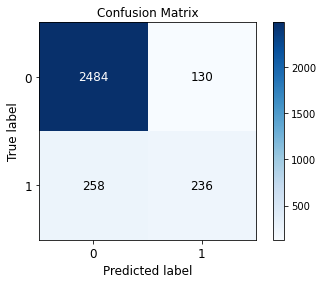

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2742
           1       0.48      0.64      0.55       366

    accuracy                           0.88      3108
   macro avg       0.71      0.78      0.74      3108
weighted avg       0.89      0.88      0.88      3108



In [ ]:
#Performance Evaluation of Naives Bayes Classifier
auc_score = roc_auc_score(ytrain, prob_train[:,1])
print ("Model ROC-AUC score for training sample: %.3f" \
                                      % auc_score)
auc_score = roc_auc_score(ytest, prob_test[:,1])
print ("Model ROC-AUC score for test sample: %.3f" \
                                      % auc_score)

#Calculate train and test accuracy
train_acc = accuracy_score(ytrain, pred_train)
test_acc  = accuracy_score(ytest, pred_test)
print ("Train Accuracy :: ", train_acc)
print ("Test Accuracy :: ", test_acc)

#Confusion Matrix
print ("\n Confusion matrix: \n")
skplt.metrics.plot_confusion_matrix(ytest, pred_test, title="Confusion Matrix",
                text_fontsize='large')
plt.show()
#Classification_report
print(classification_report(pred_test,ytest))

**XGboost**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from xgboost.sklearn import XGBClassifier

XGBoost Accuracy : 84.11%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3108
           1       0.00      0.00      0.00         0

    accuracy                           0.84      3108
   macro avg       0.50      0.42      0.46      3108
weighted avg       1.00      0.84      0.91      3108



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


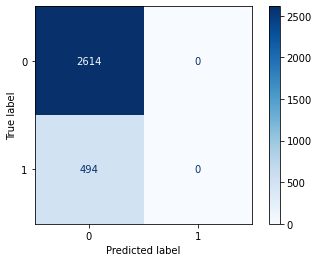

In [ ]:
xgbo = XGBClassifier()
xgbo.fit(xtrain,ytrain)
p4=xgbo.predict(xtest)
s4=accuracy_score(ytest,p4)
print("XGBoost Accuracy :", "{:.2f}%".format(100*s4))
plot_confusion_matrix(xgbo, xtest, ytest, cmap = 'Blues')
plt.grid(False)
#Classification_report
print(classification_report(p4,ytest))

##Pretrained embeddings

Pretrained Word Embeddings are the embeddings learned in one task that are used for solving another similar task.

These embeddings are trained on large datasets, saved, and then used for solving other tasks. That’s why pretrained word embeddings are a form of Transfer Learning.

Transfer learning, as the name suggests, is about transferring the learnings of one task to another. Learnings could be either weights or embeddings. In our case here, learnings are the embeddings. Hence, this concept is known as pretrained word embeddings. In the case of weights, the concept is known as a pretrained model.

Pretrained word embeddings capture the semantic and syntactic meaning of a word as they are trained on large datasets.

But why should we not learn our own embeddings? Well, learning word embeddings from scratch is a challenging problem due to two primary reasons:

Sparsity of training data:

One of the primary reasons for not doing this is the Sparsity of Training Data. Most real-world problems contain a dataset that has a large volume of rare words. The embeddings learned from these datasets cannot arrive at the right representation of the word.

In order to achieve this, the dataset must contain a rich vocabulary. Frequently occurring words build just such a rich vocabulary.

Large number of trainable parameters:

Secondly, the number of Trainable Parameters increases while learning embeddings from scratch. This results in a slower training process. Learning embeddings from scratch might also leave you in an unclear state about the representation of the words.

So, the solution to all the above problems is pretrained word embeddings. Let us discuss different pretrained word embeddings in the coming section.



Glove is a popular word-level pretrained word embedding.

The basic idea behind the GloVe word embedding is to derive the relationship between the words from Global Statistics

But how can statistics represent meaning? Let me explain.

One of the simplest ways is to look at the co-occurrence matrix. A co-occurrence matrix tells us how often a particular pair of words occur together. Each value in a co-occurrence matrix is a count of a pair of words occurring together.

Pretrained Glove Model

Create an embedding matrix by assigning the vocabulary with the pretrained word embeddings

In [ ]:
embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))

for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

print(embedding_matrix.shape)

(8551, 100)


In [ ]:
print('Shape of train sequences: ',x_train.shape)
print('Shape of train labels: ',y_train.shape)
print("Shape of Validation sequences: ",x_test.shape)
print("Shape of Validation  labels: ",y_test.shape)

Shape of train sequences:  (8286, 100)
Shape of train labels:  (8286, 1)
Shape of Validation sequences:  (2072, 100)
Shape of Validation  labels:  (2072, 1)


Pretrained embedding with glove is performed on below models

1.LSTM
2.BILSTM
3.BILSTM WITH ATTENTION
4.GRU

LSTM

In [ ]:
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=True)#creating embedding layer
PreTrainmodelLSTM = Sequential()
PreTrainmodelLSTM.add(embedding_layer)
PreTrainmodelLSTM.add(LSTM(128, return_sequences=True))#LSTM layer
PreTrainmodelLSTM.add(Flatten())
PreTrainmodelLSTM.add(Dropout(0.5))
PreTrainmodelLSTM.add(Dense(1, activation='sigmoid'))#dense layer


PreTrainmodelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])##Add loss function, metrics, optimizer
print(PreTrainmodelLSTM.summary())#Print summary of model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          855100    
                                                                 
 lstm_5 (LSTM)               (None, 100, 128)          117248    
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_5 (Dropout)         (None, 12800)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 12801     
                                                                 
Total params: 985,149
Trainable params: 985,149
Non-trainable params: 0
_________________________________________________________________
None


**Training and evaluating model**

we are training using 10 epochs

In [ ]:
historyPreTrainedmodelLSTM = PreTrainmodelLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPreTrainedmodelLSTM= PreTrainmodelLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
52/52 [==============================] - 26s 448ms/step - loss: 0.4395 - acc: 0.8306 - val_loss: 0.3326 - val_acc: 0.8540
Epoch 2/10
52/52 [==============================] - 22s 432ms/step - loss: 0.2029 - acc: 0.9169 - val_loss: 0.2327 - val_acc: 0.9210
Epoch 3/10
52/52 [==============================] - 23s 438ms/step - loss: 0.0799 - acc: 0.9710 - val_loss: 0.2399 - val_acc: 0.9282
Epoch 4/10
52/52 [==============================] - 23s 439ms/step - loss: 0.0416 - acc: 0.9858 - val_loss: 0.2569 - val_acc: 0.9373
Epoch 5/10
52/52 [==============================] - 23s 440ms/step - loss: 0.0242 - acc: 0.9932 - val_loss: 0.4474 - val_acc: 0.9324
Epoch 6/10
52/52 [==============================] - 23s 446ms/step - loss: 0.0116 - acc: 0.9968 - val_loss: 0.5588 - val_acc: 0.9300
Epoch 7/10
52/52 [==============================] - 23s 442ms/step - loss: 0.0080 - acc: 0.9979 - val_loss: 0.6161 - val_acc: 0.9373
Epoch 8/10
52/52 [==============================] - 23s 442ms/step - 

In [ ]:
y_pred = (PreTrainmodelLSTM.predict(x_test) >= 0.5).astype(int)


Accuracy : 
0.918918918918919
65/65 [==============================] - 2s 35ms/step - loss: 0.6493 - acc: 0.9189
[0.649330735206604, 0.9189189076423645]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1764
           1       0.72      0.74      0.73       308

    accuracy                           0.92      2072
   macro avg       0.84      0.85      0.84      2072
weighted avg       0.92      0.92      0.92      2072



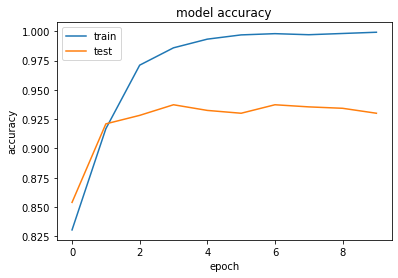

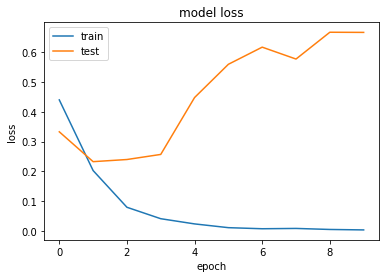

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(PreTrainmodelLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPreTrainedmodelLSTM)

When compared with the accuracy of lstm with basic model, pretrained lstm model  with glove embedding shows slight increase in the accuracy

BILSTM

In [ ]:
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=True)
PreTrainmodelBiLSTM = Sequential()
PreTrainmodelBiLSTM.add(embedding_layer)
PreTrainmodelBiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
PreTrainmodelBiLSTM.add(Flatten())
PreTrainmodelBiLSTM.add(Dropout(0.5))
PreTrainmodelBiLSTM.add(Dense(1, activation='sigmoid'))


PreTrainmodelBiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(PreTrainmodelBiLSTM.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          855100    
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 256)         234496    
 nal)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_6 (Dropout)         (None, 25600)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 25601     
                                                                 
Total params: 1,115,197
Trainable params: 1,115,197
Non-trainable params: 0
____________________________________________

In [ ]:
historyPreTrainedmodeBiLSTM = PreTrainmodelBiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPreTrainedmodelBiLSTM= PreTrainmodelBiLSTM.evaluate(x_test, y_test, verbose=1)


Epoch 1/10
52/52 [==============================] - 48s 826ms/step - loss: 0.4331 - acc: 0.8351 - val_loss: 0.3248 - val_acc: 0.8601
Epoch 2/10
52/52 [==============================] - 42s 796ms/step - loss: 0.2220 - acc: 0.9139 - val_loss: 0.2180 - val_acc: 0.9186
Epoch 3/10
52/52 [==============================] - 44s 843ms/step - loss: 0.0849 - acc: 0.9704 - val_loss: 0.2190 - val_acc: 0.9349
Epoch 4/10
52/52 [==============================] - 40s 773ms/step - loss: 0.0362 - acc: 0.9881 - val_loss: 0.3116 - val_acc: 0.9433
Epoch 5/10
52/52 [==============================] - 40s 775ms/step - loss: 0.0218 - acc: 0.9940 - val_loss: 0.5501 - val_acc: 0.9391
Epoch 6/10
52/52 [==============================] - 40s 774ms/step - loss: 0.0128 - acc: 0.9965 - val_loss: 0.2852 - val_acc: 0.9264
Epoch 7/10
52/52 [==============================] - 40s 773ms/step - loss: 0.0154 - acc: 0.9950 - val_loss: 0.5482 - val_acc: 0.9343
Epoch 8/10
52/52 [==============================] - 40s 773ms/step - 

In [ ]:
y_pred = (PreTrainmodelBiLSTM.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.9232625482625483
65/65 [==============================] - 4s 56ms/step - loss: 0.6285 - acc: 0.9233
[0.628511905670166, 0.9232625365257263]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1764
           1       0.75      0.73      0.74       308

    accuracy                           0.92      2072
   macro avg       0.85      0.84      0.85      2072
weighted avg       0.92      0.92      0.92      2072



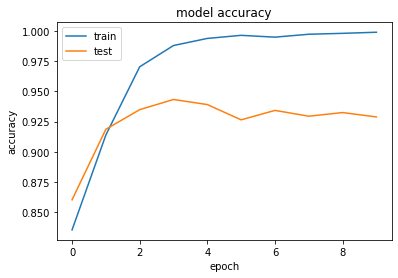

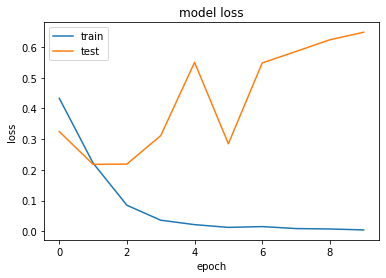

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(PreTrainmodelBiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPreTrainedmodeBiLSTM)


While comparing results we could see that BILSTM has slight increase in accuracy when compared with lstm predefined model, BILSTM has 93% accuracy .

Defining BiLSTM with Attention Layer

In [ ]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
PretrainedmodelABiLSTM = Sequential()
PretrainedmodelABiLSTM.add(embedding_layer)
PretrainedmodelABiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
PretrainedmodelABiLSTM.add(attention(return_sequences=True))
PretrainedmodelABiLSTM.add(Flatten())
PretrainedmodelABiLSTM.add(Dropout(0.5))
PretrainedmodelABiLSTM.add(Dense(1, activation='sigmoid'))


PretrainedmodelABiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(PretrainedmodelABiLSTM.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          855100    
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 256)         234496    
 nal)                                                            
                                                                 
 attention_2 (attention)     (None, 100, 256)          356       
                                                                 
 flatten_7 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_7 (Dropout)         (None, 25600)             0         
                                                                 
 dense_7 (Dense)             (None, 1)                 25601     
                                                      

In [ ]:
historyPreTrainedmodelABiLSTM = PretrainedmodelABiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPreTrainedmodelABiLSTM= PretrainedmodelABiLSTM.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 42s 735ms/step - loss: 0.4787 - acc: 0.8393 - val_loss: 0.4353 - val_acc: 0.8323
Epoch 2/10
52/52 [==============================] - 37s 710ms/step - loss: 0.3909 - acc: 0.8438 - val_loss: 0.3933 - val_acc: 0.8323
Epoch 3/10
52/52 [==============================] - 37s 717ms/step - loss: 0.3817 - acc: 0.8438 - val_loss: 0.3839 - val_acc: 0.8323
Epoch 4/10
52/52 [==============================] - 37s 708ms/step - loss: 0.3392 - acc: 0.8476 - val_loss: 0.3302 - val_acc: 0.8559
Epoch 5/10
52/52 [==============================] - 37s 711ms/step - loss: 0.3036 - acc: 0.8746 - val_loss: 0.3103 - val_acc: 0.8631
Epoch 6/10
52/52 [==============================] - 37s 716ms/step - loss: 0.2808 - acc: 0.8814 - val_loss: 0.2914 - val_acc: 0.8739
Epoch 7/10
52/52 [==============================] - 37s 712ms/step - loss: 0.2669 - acc: 0.8884 - val_loss: 0.2737 - val_acc: 0.8830
Epoch 8/10
52/52 [==============================] - 37s 712ms/step - 

In [ ]:
y_pred = (PretrainedmodelABiLSTM.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.8904440154440154
65/65 [==============================] - 2s 35ms/step - loss: 0.6493 - acc: 0.9189
[0.649330735206604, 0.9189189076423645]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1764
           1       0.62      0.67      0.65       308

    accuracy                           0.89      2072
   macro avg       0.78      0.80      0.79      2072
weighted avg       0.89      0.89      0.89      2072



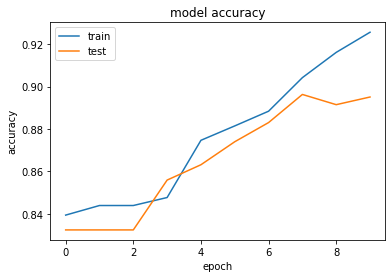

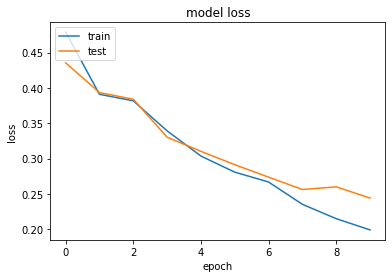

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(PreTrainmodelLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPreTrainedmodelABiLSTM)

Coming to BIlstm with attention it didnt perform well on our model compared to LSTM and BILSTM

GRU basic model

GRU’s were created as the solution to short-term memory. They have internal mechanisms called gates that can regulate the flow of information.

These gates can learn which data in a sequence is important to keep or throw away. By doing that, it can pass relevant information down the long chain of sequences to make predictions. Almost all state of the art results based on recurrent neural networks are achieved with these two networks. LSTM’s and GRU’s can be found in speech recognition, speech synthesis, and text generation. You can even use them to generate captions for videos.

Ok, so by the end of this post you should have a solid understanding of why LSTM’s and GRU’s are good at processing long sequences. I am going to approach this with intuitive explanations and illustrations and avoid as much math as possible.

In [ ]:
!pip install transformers

In [ ]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout

In [ ]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
PretrainedmodelGRU = Sequential()
PretrainedmodelGRU.add(embedding_layer)
PretrainedmodelGRU.add(GRU(128, return_sequences=True))
PretrainedmodelGRU.add(Flatten())
PretrainedmodelGRU.add(Dropout(0.5))
PretrainedmodelGRU.add(Dense(1, activation='sigmoid'))


PretrainedmodelGRU.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(PretrainedmodelGRU.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 100)          855100    
                                                                 
 gru (GRU)                   (None, 100, 128)          88320     
                                                                 
 flatten_8 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_8 (Dropout)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 1)                 12801     
                                                                 
Total params: 956,221
Trainable params: 101,121
Non-trainable params: 855,100
_________________________________________________________________
None


In [ ]:
historyPreTrainedmodelGRU = PretrainedmodelGRU.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPreTrainedmodelGRU= PretrainedmodelGRU.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 19s 315ms/step - loss: 0.4172 - acc: 0.8361 - val_loss: 0.3600 - val_acc: 0.8462
Epoch 2/10
52/52 [==============================] - 16s 305ms/step - loss: 0.3155 - acc: 0.8632 - val_loss: 0.2968 - val_acc: 0.8691
Epoch 3/10
52/52 [==============================] - 16s 304ms/step - loss: 0.2691 - acc: 0.8856 - val_loss: 0.2648 - val_acc: 0.8830
Epoch 4/10
52/52 [==============================] - 16s 304ms/step - loss: 0.2328 - acc: 0.9031 - val_loss: 0.2454 - val_acc: 0.8908
Epoch 5/10
52/52 [==============================] - 17s 330ms/step - loss: 0.2032 - acc: 0.9170 - val_loss: 0.2372 - val_acc: 0.8932
Epoch 6/10
52/52 [==============================] - 28s 546ms/step - loss: 0.1763 - acc: 0.9279 - val_loss: 0.2703 - val_acc: 0.8872
Epoch 7/10
52/52 [==============================] - 31s 594ms/step - loss: 0.1566 - acc: 0.9351 - val_loss: 0.1903 - val_acc: 0.9192
Epoch 8/10
52/52 [==============================] - 28s 542ms/step - 

In [ ]:
y_pred = (PretrainedmodelGRU.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.9251930501930502
65/65 [==============================] - 2s 28ms/step - loss: 0.2189 - acc: 0.9252
[0.21885237097740173, 0.9251930713653564]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1764
           1       0.73      0.80      0.76       308

    accuracy                           0.93      2072
   macro avg       0.84      0.87      0.86      2072
weighted avg       0.93      0.93      0.93      2072



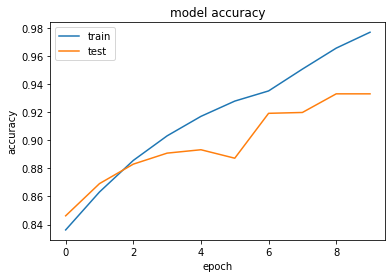

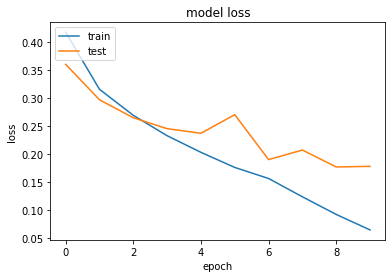

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(PretrainedmodelGRU.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPreTrainedmodelGRU)

GRU Model performed well when compared with BILSTM with attention, it has almost similar accuracy like BILSTM MODEL.

Pretrained Word2Vec¶

Google’s Word2vec Pretrained Word Embedding

Word2Vec is one of the most popular pretrained word embeddings developed by Google. Word2Vec is trained on the Google News dataset (about 100 billion words). It has several use cases such as Recommendation Engines, Knowledge Discovery, and also applied in the different Text Classification problems.

The architecture of Word2Vec is really simple. It’s a feed-forward neural network with just one hidden layer. Hence, it is sometimes referred to as a Shallow Neural Network architecture.

In [ ]:
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pretrain_w2v = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin'

In [ ]:
pretrain_w2v_model = KeyedVectors.load_word2vec_format(pretrain_w2v, binary=True)

In [ ]:
pretrain_w2v_embedding_matrix = np.zeros((vocab_size,300))
for word,index in tokenizer.word_index.items():
    try:
        embedding_value = pretrain_w2v_model[word]
        if embedding_value is not None:
            pretrain_w2v_embedding_matrix[index] = embedding_value         
    except KeyError:
        pretrain_w2v_embedding_matrix[index]=np.random.normal(0,np.sqrt(0.25),300)  

w2v embedding with lstm

In [ ]:
w2v_embedding_layer = Embedding(vocab_size, 300, weights=[pretrain_w2v_embedding_matrix], input_length=maxlen , trainable=False)
Pretrain_w2vmodelLSTM = Sequential()
Pretrain_w2vmodelLSTM.add(w2v_embedding_layer)
Pretrain_w2vmodelLSTM.add(LSTM(128, return_sequences=True))

Pretrain_w2vmodelLSTM.add(Flatten())
Pretrain_w2vmodelLSTM.add(Dropout(0.5))
Pretrain_w2vmodelLSTM.add(Dense(1, activation='sigmoid'))


Pretrain_w2vmodelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_w2vmodelLSTM.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 300)          2565300   
                                                                 
 lstm_5 (LSTM)               (None, 100, 128)          219648    
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_6 (Dropout)         (None, 12800)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 12801     
                                                                 
Total params: 2,797,749
Trainable params: 232,449
Non-trainable params: 2,565,300
_________________________________________________________________
None


In [ ]:
historyPretrain_w2vmodelLSTM = Pretrain_w2vmodelLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_w2vmodelLSTM= Pretrain_w2vmodelLSTM.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 33s 487ms/step - loss: 0.4001 - acc: 0.8440 - val_loss: 0.3092 - val_acc: 0.8721
Epoch 2/10
52/52 [==============================] - 24s 453ms/step - loss: 0.2896 - acc: 0.8721 - val_loss: 0.2839 - val_acc: 0.8818
Epoch 3/10
52/52 [==============================] - 24s 455ms/step - loss: 0.2534 - acc: 0.8935 - val_loss: 0.2530 - val_acc: 0.8860
Epoch 4/10
52/52 [==============================] - 24s 456ms/step - loss: 0.2169 - acc: 0.9081 - val_loss: 0.2603 - val_acc: 0.8806
Epoch 5/10
52/52 [==============================] - 24s 453ms/step - loss: 0.2084 - acc: 0.9155 - val_loss: 0.2533 - val_acc: 0.8764
Epoch 6/10
52/52 [==============================] - 24s 456ms/step - loss: 0.1724 - acc: 0.9311 - val_loss: 0.2310 - val_acc: 0.9065
Epoch 7/10
52/52 [==============================] - 24s 456ms/step - loss: 0.1387 - acc: 0.9457 - val_loss: 0.2098 - val_acc: 0.9107
Epoch 8/10
52/52 [==============================] - 24s 454ms/step - 

In [ ]:
y_pred = (Pretrain_w2vmodelLSTM.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.9251930501930502
65/65 [==============================] - 6s 88ms/step - loss: 0.2308 - acc: 0.9252
[0.2308078557252884, 0.9251930713653564]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1764
           1       0.76      0.73      0.74       308

    accuracy                           0.93      2072
   macro avg       0.86      0.84      0.85      2072
weighted avg       0.92      0.93      0.92      2072



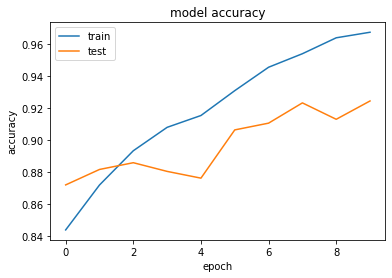

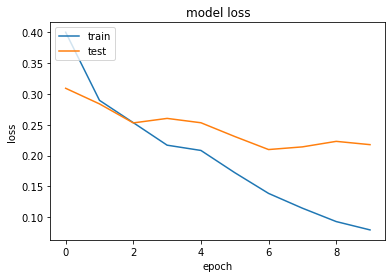

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_w2vmodelLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_w2vmodelLSTM)

w2v lstm has a accuracy of 92% which is slightly less than glove lstm, glove embedding works well when compared with w2v lstm

w2v BiLSTM

In [ ]:
w2v_embedding_layer = Embedding(vocab_size, 300, weights=[pretrain_w2v_embedding_matrix], input_length=maxlen , trainable=False)
Pretrain_w2vmodelBiLSTM = Sequential()
Pretrain_w2vmodelBiLSTM.add(w2v_embedding_layer)
Pretrain_w2vmodelBiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))

Pretrain_w2vmodelBiLSTM.add(Flatten())
Pretrain_w2vmodelBiLSTM.add(Dropout(0.5))
Pretrain_w2vmodelBiLSTM.add(Dense(1, activation='sigmoid'))


Pretrain_w2vmodelBiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_w2vmodelBiLSTM.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 300)          2565300   
                                                                 
 bidirectional_5 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 25600)             0         
                                                                 
 dropout_10 (Dropout)        (None, 25600)             0         
                                                                 
 dense_10 (Dense)            (None, 1)                 25601     
                                                                 
Total params: 3,030,197
Trainable params: 464,897
Non-trainable params: 2,565,300
_____________________________________

In [ ]:
historyPretrain_w2vmodelBiLSTM = Pretrain_w2vmodelBiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_w2vmodelBiLSTM= Pretrain_w2vmodelBiLSTM.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 51s 910ms/step - loss: 0.4173 - acc: 0.8351 - val_loss: 0.3302 - val_acc: 0.8589
Epoch 2/10
52/52 [==============================] - 49s 939ms/step - loss: 0.2853 - acc: 0.8781 - val_loss: 0.2815 - val_acc: 0.8727
Epoch 3/10
52/52 [==============================] - 46s 885ms/step - loss: 0.2343 - acc: 0.9021 - val_loss: 0.2749 - val_acc: 0.8703
Epoch 4/10
52/52 [==============================] - 48s 909ms/step - loss: 0.1955 - acc: 0.9209 - val_loss: 0.2379 - val_acc: 0.8987
Epoch 5/10
52/52 [==============================] - 46s 880ms/step - loss: 0.1567 - acc: 0.9360 - val_loss: 0.2282 - val_acc: 0.9138
Epoch 6/10
52/52 [==============================] - 46s 883ms/step - loss: 0.1299 - acc: 0.9490 - val_loss: 0.2240 - val_acc: 0.9156
Epoch 7/10
52/52 [==============================] - 46s 884ms/step - loss: 0.0990 - acc: 0.9624 - val_loss: 0.2243 - val_acc: 0.9150
Epoch 8/10
52/52 [==============================] - 46s 882ms/step - 

In [ ]:
y_pred = (Pretrain_w2vmodelBiLSTM.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.9251930501930502
65/65 [==============================] - 10s 157ms/step - loss: 0.3189 - acc: 0.9252
[0.3188759982585907, 0.9251930713653564]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1764
           1       0.75      0.74      0.75       308

    accuracy                           0.93      2072
   macro avg       0.85      0.85      0.85      2072
weighted avg       0.92      0.93      0.92      2072



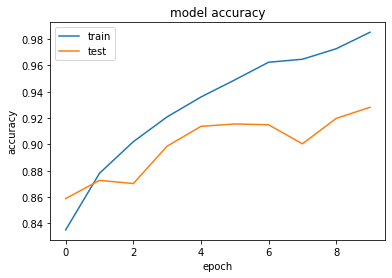

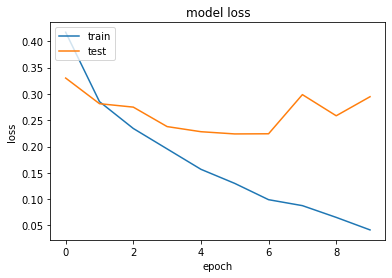

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_w2vmodelBiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_w2vmodelBiLSTM)

w2v BIlstm has a accuracy of 92% which is slightly less than glove lstm, glove embedding works well when compared with w2v BILSTM

w2v with Bilstm and attention layer

In [ ]:
w2v_embedding_layer = Embedding(vocab_size, 300, weights=[pretrain_w2v_embedding_matrix], input_length=maxlen , trainable=False)
Pretrain_w2vmodelABiLSTM = Sequential()
Pretrain_w2vmodelABiLSTM.add(w2v_embedding_layer)
Pretrain_w2vmodelABiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
Pretrain_w2vmodelABiLSTM.add(attention(return_sequences=True))
Pretrain_w2vmodelABiLSTM.add(Flatten())
Pretrain_w2vmodelABiLSTM.add(Dropout(0.5))
Pretrain_w2vmodelABiLSTM.add(Dense(1, activation='sigmoid'))


Pretrain_w2vmodelABiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_w2vmodelABiLSTM.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 300)          2565300   
                                                                 
 bidirectional_6 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 attention_3 (attention)     (None, 100, 256)          356       
                                                                 
 flatten_11 (Flatten)        (None, 25600)             0         
                                                                 
 dropout_11 (Dropout)        (None, 25600)             0         
                                                                 
 dense_11 (Dense)            (None, 1)                 25601     
                                                     

In [ ]:
historyPretrain_w2vmodelABiLSTM = Pretrain_w2vmodelABiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_w2vmodelABiLSTM= Pretrain_w2vmodelABiLSTM.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 75s 1s/step - loss: 0.4947 - acc: 0.8352 - val_loss: 0.4503 - val_acc: 0.8323
Epoch 2/10
52/52 [==============================] - 61s 1s/step - loss: 0.4272 - acc: 0.8438 - val_loss: 0.4176 - val_acc: 0.8323
Epoch 3/10
52/52 [==============================] - 63s 1s/step - loss: 0.3634 - acc: 0.8463 - val_loss: 0.3726 - val_acc: 0.8559
Epoch 4/10
52/52 [==============================] - 47s 912ms/step - loss: 0.3054 - acc: 0.8749 - val_loss: 0.3322 - val_acc: 0.8721
Epoch 5/10
52/52 [==============================] - 48s 934ms/step - loss: 0.2594 - acc: 0.8930 - val_loss: 0.2614 - val_acc: 0.8938
Epoch 6/10
52/52 [==============================] - 47s 906ms/step - loss: 0.2306 - acc: 0.9018 - val_loss: 0.2592 - val_acc: 0.8920
Epoch 7/10
52/52 [==============================] - 49s 937ms/step - loss: 0.1963 - acc: 0.9200 - val_loss: 0.2368 - val_acc: 0.9047
Epoch 8/10
52/52 [==============================] - 47s 910ms/step - loss: 0.1

In [ ]:
y_pred = (Pretrain_w2vmodelABiLSTM.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.9025096525096525
65/65 [==============================] - 10s 158ms/step - loss: 0.2604 - acc: 0.9025
[0.2604229748249054, 0.9025096297264099]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1764
           1       0.70      0.60      0.65       308

    accuracy                           0.90      2072
   macro avg       0.82      0.78      0.80      2072
weighted avg       0.90      0.90      0.90      2072



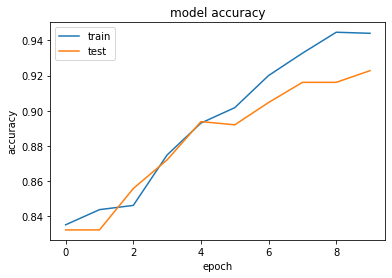

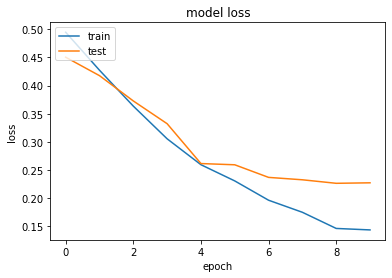

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_w2vmodelABiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_w2vmodelABiLSTM)

w2v bi lstm with attention has same accuracy as glove bilstm with attention
though its similar glove has more advantages than word2vec in terms of embedding

W2V model with GRU

In [ ]:
w2v_embedding_layer = Embedding(vocab_size, 300, weights=[pretrain_w2v_embedding_matrix], input_length=maxlen , trainable=False)
Pretrain_w2vmodelGRU = Sequential()
Pretrain_w2vmodelGRU.add(w2v_embedding_layer)
Pretrain_w2vmodelGRU.add(GRU(128, return_sequences=True))

Pretrain_w2vmodelGRU.add(Flatten())
Pretrain_w2vmodelGRU.add(Dropout(0.5))
Pretrain_w2vmodelGRU.add(Dense(1, activation='sigmoid'))


Pretrain_w2vmodelGRU.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_w2vmodelGRU.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 300)          2565300   
                                                                 
 gru_4 (GRU)                 (None, 100, 128)          165120    
                                                                 
 flatten_9 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_9 (Dropout)         (None, 12800)             0         
                                                                 
 dense_9 (Dense)             (None, 1)                 12801     
                                                                 
Total params: 2,743,221
Trainable params: 177,921
Non-trainable params: 2,565,300
_________________________________________________________________
None


In [ ]:
historyPretrain_w2vmodelGRU = Pretrain_w2vmodelGRU.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_w2vmodelGRU= Pretrain_w2vmodelGRU.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 28s 465ms/step - loss: 0.4265 - acc: 0.8363 - val_loss: 0.3597 - val_acc: 0.8390
Epoch 2/10
52/52 [==============================] - 20s 391ms/step - loss: 0.2955 - acc: 0.8795 - val_loss: 0.2811 - val_acc: 0.8842
Epoch 3/10
52/52 [==============================] - 20s 390ms/step - loss: 0.2399 - acc: 0.8998 - val_loss: 0.2508 - val_acc: 0.8890
Epoch 4/10
52/52 [==============================] - 20s 386ms/step - loss: 0.2046 - acc: 0.9176 - val_loss: 0.2282 - val_acc: 0.9083
Epoch 5/10
52/52 [==============================] - 20s 389ms/step - loss: 0.1646 - acc: 0.9353 - val_loss: 0.2009 - val_acc: 0.9174
Epoch 6/10
52/52 [==============================] - 20s 388ms/step - loss: 0.1362 - acc: 0.9446 - val_loss: 0.2057 - val_acc: 0.9144
Epoch 7/10
52/52 [==============================] - 20s 388ms/step - loss: 0.1191 - acc: 0.9522 - val_loss: 0.2112 - val_acc: 0.9180
Epoch 8/10
52/52 [==============================] - 20s 388ms/step - 

In [ ]:
y_pred = (Pretrain_w2vmodelGRU.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.9333976833976834
65/65 [==============================] - 2s 37ms/step - loss: 0.2344 - acc: 0.9334
[0.23435895144939423, 0.9333977103233337]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1764
           1       0.78      0.78      0.78       308

    accuracy                           0.93      2072
   macro avg       0.87      0.87      0.87      2072
weighted avg       0.93      0.93      0.93      2072



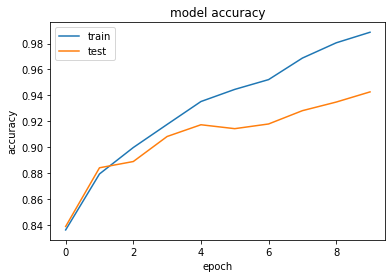

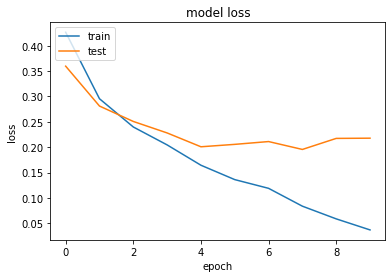

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_w2vmodelGRU.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_w2vmodelGRU)

word2vec gru has same accuracy has glove gru model

FAST TEXT with LSTM

The main principle behind fastText is that the morphological structure of a word carries important information about the meaning of the word. Such structure is not taken into account by traditional word embeddings like Word2Vec, which train a unique word embedding for every individual word. This is especially significant for morphologically rich languages (German, Turkish) in which a single word can have a large number of morphological forms, each of which might occur rarely, thus making it hard to train good word embeddings.

fastText attempts to solve this by treating each word as the aggregation of its subwords. For the sake of simplicity and language-independence, subwords are taken to be the character ngrams of the word. The vector for a word is simply taken to be the sum of all vectors of its component char-ngrams.

The main principle behind fastText is that the morphological structure of a word carries important information about the meaning of the word. Such structure is not taken into account by traditional word embeddings like Word2Vec, which train a unique word embedding for every individual word. This is especially significant for morphologically rich languages (German, Turkish) in which a single word can have a large number of morphological forms, each of which might occur rarely, thus making it hard to train good word embeddings.

fastText attempts to solve this by treating each word as the aggregation of its subwords. For the sake of simplicity and language-independence, subwords are taken to be the character ngrams of the word. The vector for a word is simply taken to be the sum of all vectors of its component char-ngrams.

In [ ]:
import numpy as np

In [ ]:
pretrain_ft = '/content/drive/MyDrive/wiki-news-300d-1M.vec'

In [ ]:
def get_coefs(word,*arr): 
  return word, np.asarray(arr, dtype='float32')
ft_embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(pretrain_ft) if len(o)>100)

In [ ]:
ft_embs = np.stack(ft_embeddings_index.values())
emb_mean,emb_std = ft_embs.mean(), ft_embs.std()
ft_embed_size = ft_embs.shape[1]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [ ]:
ft_embedding_matrix = np.random.normal(emb_mean, emb_std, (vocab_size, ft_embed_size))
for word, index in tokenizer.word_index.items():
    ft_embedding_vector = ft_embeddings_index.get(word)
    if ft_embedding_vector is not None: 
      ft_embedding_matrix[index] = ft_embedding_vector

in the above embedding matrix is created.

In [ ]:
ft_embedding_layer = Embedding(vocab_size, 300, weights=[ft_embedding_matrix], input_length=maxlen , trainable=False)#creating embedding layer
Pretrain_ftmodelLSTM = Sequential()
Pretrain_ftmodelLSTM.add(ft_embedding_layer)
Pretrain_ftmodelLSTM.add(LSTM(128, return_sequences=True))

Pretrain_ftmodelLSTM.add(Flatten())
Pretrain_ftmodelLSTM.add(Dropout(0.5))
Pretrain_ftmodelLSTM.add(Dense(1, activation='sigmoid'))


Pretrain_ftmodelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_ftmodelLSTM.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          2565300   
                                                                 
 lstm_2 (LSTM)               (None, 100, 128)          219648    
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_1 (Dropout)         (None, 12800)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 12801     
                                                                 
Total params: 2,797,749
Trainable params: 232,449
Non-trainable params: 2,565,300
_________________________________________________________________
None


In [ ]:
#Running the model
historyPretrain_ftmodelLSTM = Pretrain_ftmodelLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_ftmodelLSTM= Pretrain_ftmodelLSTM.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 30s 544ms/step - loss: 0.4396 - acc: 0.8435 - val_loss: 0.4255 - val_acc: 0.8323
Epoch 2/10
52/52 [==============================] - 38s 724ms/step - loss: 0.3565 - acc: 0.8485 - val_loss: 0.3362 - val_acc: 0.8655
Epoch 3/10
52/52 [==============================] - 30s 569ms/step - loss: 0.3002 - acc: 0.8695 - val_loss: 0.2891 - val_acc: 0.8806
Epoch 4/10
52/52 [==============================] - 24s 462ms/step - loss: 0.2696 - acc: 0.8861 - val_loss: 0.2701 - val_acc: 0.8836
Epoch 5/10
52/52 [==============================] - 37s 710ms/step - loss: 0.2436 - acc: 0.8939 - val_loss: 0.2611 - val_acc: 0.8932
Epoch 6/10
52/52 [==============================] - 35s 672ms/step - loss: 0.2107 - acc: 0.9125 - val_loss: 0.2513 - val_acc: 0.9005
Epoch 7/10
52/52 [==============================] - 34s 657ms/step - loss: 0.1904 - acc: 0.9243 - val_loss: 0.2401 - val_acc: 0.9083
Epoch 8/10
52/52 [==============================] - 24s 457ms/step - 

In [ ]:
y_pred = (Pretrain_ftmodelLSTM.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.9078185328185329
65/65 [==============================] - 4s 64ms/step - loss: 0.2635 - acc: 0.9078
[0.2635268270969391, 0.9078185558319092]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1764
           1       0.69      0.70      0.69       308

    accuracy                           0.91      2072
   macro avg       0.82      0.82      0.82      2072
weighted avg       0.91      0.91      0.91      2072



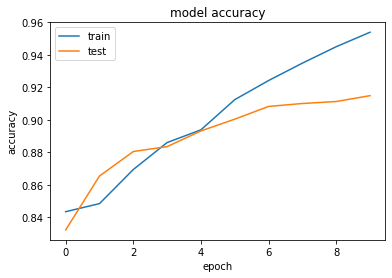

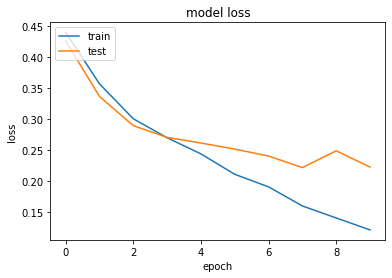

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_ftmodelLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_ftmodelLSTM)

fasttext lstm has less accuracy when compared to glove and word2vec

FAST TEXT MODEL With BiLSTM

In [ ]:
ft_embedding_layer = Embedding(vocab_size, 300, weights=[ft_embedding_matrix], input_length=maxlen , trainable=False)
Pretrain_ftmodelBiLSTM = Sequential()
Pretrain_ftmodelBiLSTM.add(ft_embedding_layer)
Pretrain_ftmodelBiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))

Pretrain_ftmodelBiLSTM.add(Flatten())
Pretrain_ftmodelBiLSTM.add(Dropout(0.5))
Pretrain_ftmodelBiLSTM.add(Dense(1, activation='sigmoid'))


Pretrain_ftmodelBiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_ftmodelBiLSTM.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          2565300   
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_2 (Dropout)         (None, 25600)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 25601     
                                                                 
Total params: 3,030,197
Trainable params: 464,897
Non-trainable params: 2,565,300
______________________________________

In [ ]:
#Running the model
historyPretrain_ftmodelBiLSTM = Pretrain_ftmodelBiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_ftmodelBiLSTM= Pretrain_ftmodelBiLSTM.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 53s 942ms/step - loss: 0.4421 - acc: 0.8298 - val_loss: 0.4020 - val_acc: 0.8323
Epoch 2/10
52/52 [==============================] - 50s 958ms/step - loss: 0.3494 - acc: 0.8518 - val_loss: 0.3041 - val_acc: 0.8661
Epoch 3/10
52/52 [==============================] - 47s 908ms/step - loss: 0.2962 - acc: 0.8733 - val_loss: 0.2943 - val_acc: 0.8715
Epoch 4/10
52/52 [==============================] - 47s 906ms/step - loss: 0.2585 - acc: 0.8873 - val_loss: 0.2549 - val_acc: 0.8872
Epoch 5/10
52/52 [==============================] - 48s 915ms/step - loss: 0.2241 - acc: 0.9087 - val_loss: 0.2414 - val_acc: 0.8999
Epoch 6/10
52/52 [==============================] - 47s 902ms/step - loss: 0.2040 - acc: 0.9202 - val_loss: 0.2333 - val_acc: 0.9041
Epoch 7/10
52/52 [==============================] - 47s 900ms/step - loss: 0.1758 - acc: 0.9274 - val_loss: 0.2203 - val_acc: 0.9107
Epoch 8/10
52/52 [==============================] - 47s 910ms/step - 

In [ ]:
y_pred = (Pretrain_ftmodelBiLSTM.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.8682432432432432
65/65 [==============================] - 7s 109ms/step - loss: 0.3031 - acc: 0.8682
[0.3030523359775543, 0.8682432174682617]
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1764
           1       0.54      0.85      0.66       308

    accuracy                           0.87      2072
   macro avg       0.75      0.86      0.79      2072
weighted avg       0.91      0.87      0.88      2072



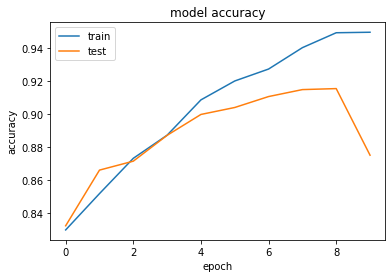

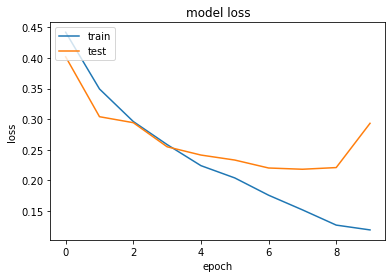

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_ftmodelBiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_ftmodelBiLSTM)

Fasttext BIlSTM has very less accuracy when compared with w2v BILSTM and glove BILSTM.

FASTTEXT BiLSTM with attention

In [ ]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout

In [ ]:
ft_embedding_layer = Embedding(vocab_size, 300, weights=[ft_embedding_matrix], input_length=maxlen , trainable=False)
Pretrain_ftmodelABiLSTM = Sequential()
Pretrain_ftmodelABiLSTM.add(ft_embedding_layer)
Pretrain_ftmodelABiLSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
Pretrain_ftmodelABiLSTM.add(attention(return_sequences=True))
Pretrain_ftmodelABiLSTM.add(Flatten())
Pretrain_ftmodelABiLSTM.add(Dropout(0.5))
Pretrain_ftmodelABiLSTM.add(Dense(1, activation='sigmoid'))


Pretrain_ftmodelABiLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_ftmodelABiLSTM.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          2565300   
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 256)         439296    
 nal)                                                            
                                                                 
 attention (attention)       (None, 100, 256)          356       
                                                                 
 flatten_3 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25600)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25601     
                                                      

In [ ]:
#Running the model
historyPretrain_ftmodelABiLSTM = Pretrain_ftmodelABiLSTM.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_ftmodelABiLSTM= Pretrain_ftmodelABiLSTM.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 54s 958ms/step - loss: 0.4665 - acc: 0.8381 - val_loss: 0.4551 - val_acc: 0.8323
Epoch 2/10
52/52 [==============================] - 48s 933ms/step - loss: 0.4284 - acc: 0.8438 - val_loss: 0.4338 - val_acc: 0.8323
Epoch 3/10
52/52 [==============================] - 49s 942ms/step - loss: 0.4132 - acc: 0.8438 - val_loss: 0.4160 - val_acc: 0.8323
Epoch 4/10
52/52 [==============================] - 48s 932ms/step - loss: 0.3792 - acc: 0.8438 - val_loss: 0.3740 - val_acc: 0.8329
Epoch 5/10
52/52 [==============================] - 51s 985ms/step - loss: 0.3365 - acc: 0.8526 - val_loss: 0.3313 - val_acc: 0.8510
Epoch 6/10
52/52 [==============================] - 51s 974ms/step - loss: 0.3048 - acc: 0.8678 - val_loss: 0.3167 - val_acc: 0.8625
Epoch 7/10
52/52 [==============================] - 49s 942ms/step - loss: 0.2871 - acc: 0.8793 - val_loss: 0.2896 - val_acc: 0.8806
Epoch 8/10
52/52 [==============================] - 49s 938ms/step - 

In [ ]:
y_pred = (Pretrain_ftmodelABiLSTM.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.9073359073359073
65/65 [==============================] - 7s 111ms/step - loss: 0.2401 - acc: 0.9073
[0.24010729789733887, 0.9073359370231628]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1764
           1       0.67      0.75      0.71       308

    accuracy                           0.91      2072
   macro avg       0.81      0.84      0.83      2072
weighted avg       0.91      0.91      0.91      2072



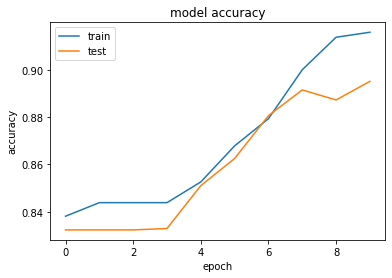

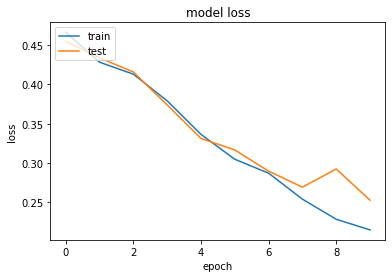

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_ftmodelABiLSTM.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_ftmodelABiLSTM)

Fast text BILSTM with attention has less accuracy when compared with word2vec BILSTM with attention, but slightly more than Glove BILSTM with attention

FAST TEXT with GRU

In [ ]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout

In [ ]:
ft_embedding_layer = Embedding(vocab_size, 300, weights=[ft_embedding_matrix], input_length=maxlen , trainable=False)
Pretrain_ftmodelGRU = Sequential()
Pretrain_ftmodelGRU.add(ft_embedding_layer)
Pretrain_ftmodelGRU.add(GRU(128, return_sequences=True))
Pretrain_ftmodelGRU.add(attention(return_sequences=True))
Pretrain_ftmodelGRU.add(Flatten())
Pretrain_ftmodelGRU.add(Dropout(0.5))
Pretrain_ftmodelGRU.add(Dense(1, activation='sigmoid'))


Pretrain_ftmodelGRU.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(Pretrain_ftmodelGRU.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 300)          2565300   
                                                                 
 gru_1 (GRU)                 (None, 100, 128)          165120    
                                                                 
 attention_2 (attention)     (None, 100, 128)          228       
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_5 (Dropout)         (None, 12800)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 12801     
                                                                 
Total params: 2,743,449
Trainable params: 178,149
Non-

In [ ]:
#Running the model
historyPretrain_ftmodelGRU= Pretrain_ftmodelGRU.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

scoreTestPretrain_ftmodelGRU= Pretrain_ftmodelGRU.evaluate(x_test, y_test, verbose=1)

Epoch 1/10
52/52 [==============================] - 38s 639ms/step - loss: 0.4855 - acc: 0.8361 - val_loss: 0.4520 - val_acc: 0.8323
Epoch 2/10
52/52 [==============================] - 31s 607ms/step - loss: 0.4320 - acc: 0.8438 - val_loss: 0.4524 - val_acc: 0.8323
Epoch 3/10
52/52 [==============================] - 32s 615ms/step - loss: 0.4214 - acc: 0.8438 - val_loss: 0.4229 - val_acc: 0.8323
Epoch 4/10
52/52 [==============================] - 21s 411ms/step - loss: 0.3901 - acc: 0.8438 - val_loss: 0.3743 - val_acc: 0.8323
Epoch 5/10
52/52 [==============================] - 21s 400ms/step - loss: 0.3346 - acc: 0.8503 - val_loss: 0.3165 - val_acc: 0.8649
Epoch 6/10
52/52 [==============================] - 21s 406ms/step - loss: 0.2827 - acc: 0.8897 - val_loss: 0.2783 - val_acc: 0.8969
Epoch 7/10
52/52 [==============================] - 22s 422ms/step - loss: 0.2504 - acc: 0.9093 - val_loss: 0.2775 - val_acc: 0.8872
Epoch 8/10
52/52 [==============================] - 21s 403ms/step - 

In [ ]:
y_pred = (Pretrain_ftmodelGRU.predict(x_test) >= 0.5).astype(int)

Accuracy : 
0.916023166023166
65/65 [==============================] - 3s 38ms/step - loss: 0.2151 - acc: 0.9160
[0.2150605469942093, 0.9160231947898865]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1764
           1       0.72      0.72      0.72       308

    accuracy                           0.92      2072
   macro avg       0.83      0.83      0.83      2072
weighted avg       0.92      0.92      0.92      2072



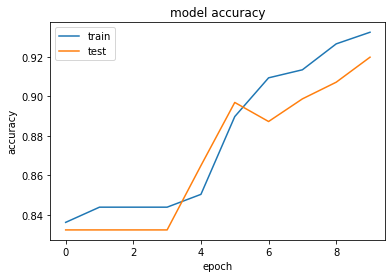

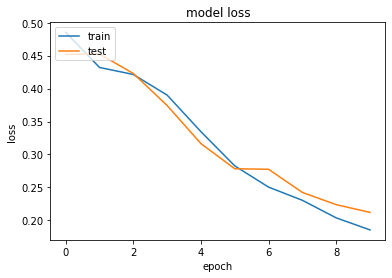

In [ ]:
print("Accuracy : ")
print(accuracy_score(y_test, y_pred))
print(Pretrain_ftmodelGRU.evaluate(x_test, y_test))
print(classification_report(y_test, y_pred))
show_performance_plot(historyPretrain_ftmodelGRU)

Fast text GRU model performace itsnt good when compared with glove and word2vec gru model.

Word2vec:
Advantages:

The idea is very intuitive, which transforms the unlabled raw corpus into labeled data (by mapping the target word to its context word), and learns the representation of words in a classification task.
The data can be fed into the model in an online way and needs little preprocessing, thus requires little memory.
The mapping between the target word to its context word implicitly embeds the sub-linear relationship into the vector space of words, so that relationships like “king:man as queen:woman” can be infered by word vectors.
It is simple for a freshman to understand the principle and do implementation.
Disadvantages:

The sub-linear relationships are not explicitly defined. There is little theoretical support behind such characteristic.
The model could be very difficult to train if use the softmax function, since the number of categories is too large (the size of vocabulary). Though approxination algorithms like negative sampling (NEG) and hierarchical softmax (HS) are proposed to address the issue, other problems happen. For example, the word vectors by NEG are not distributed uniformally, they are located within a cone in the vector space hence the vector space is not sufficiently utilized.

Glove:

Advantages:

The goal of Glove is very straightforward, i.e., to enforce the word vectors to capture sub-linear relationships in the vector space. Thus, it proves to perform better than Word2vec in the word analogoy tasks.
Glove adds some more practical meaning into word vectors by considering the relationships between word pair and word pair rather than word and word.
Glove gives lower weight for highly frequent word pairs so as to prevent the meaningless stop words like “the”, “an” will not dominate the training progress.
Disadvantages:

The model is trained on the co-occurrence matrix of words, which takes a lot of memory for storage. Especially, if you change the hyper-parameters related to the co-occurrence matrix, you have to reconstruct the matrix again, which is very time-consuming.

Fast Text :
In fastText, a low-dimensional vector is associated with each word. Hidden representations are shared among all classifiers in different categories, so that text information can be used in different categories. This type of representation is called a bag of words (word order is ignored here). In fastText, the vector representation of the word n-gram is also used to take the local word order into account, which is very important for many text classification problems.
 

 fastText word vector advantage

(1) Suitable for large-scale data + efficient training speed: It can train the model to "process more than 1 billion words in 10 minutes under the condition of using a standard multi-core CPU." Especially compared with the deep model, fastText can reduce the training time by several days Shorten to a few seconds. Using a standard multi-core CPU, the result of training a model with more than 1 billion vocabulary in 10 minutes. In addition, fastText can divide 500,000 sentences into more than 300,000 categories in five minutes. 

(2) Support for multilingual expression: Using its language structure, fastText can be designed to support multiple languages ​​including English, German, Spanish, French and Czech. It also uses a simple and efficient way to incorporate sub-character information. This method performs very well when used in a language with rich morphology like Czech, which also proves the carefully designed character n-gram feature It is an important source of rich vocabulary representation. The performance of FastText is significantly better than the popular word2vec tool, and it is also better than other current most advanced morphological vocabulary representations.

Comparison of FastText word vector and word2vec
This section comes from the blog: fasttextFastText = flexible use of cbow + h-softmax in word2vec

Flexibility is reflected in two aspects:

The output layer of the model: the output layer of word2vec, which corresponds to each term, has the largest probability of calculating a certain term; and the output layer of fasttext corresponds to the classified label. However, no matter what content the output layer corresponds to, the corresponding vector will not be retained and used;
The input layer of the model: the output layer of word2vec is the term in the context window; and the content of the entire sentence corresponding to fasttext, including the term and n-gram;
The essential difference between the two is reflected in the use of h-softmax. The purpose of Wordvec is to obtain a word vector, which is finally obtained in the input layer. The h-softmax corresponding to the output layer will also generate a series of vectors, but they are eventually discarded and will not be used.

Fasttext makes full use of the classification function of h-softmax, traverses all the leaf nodes of the classification tree, and finds the label with the highest probability (one or N)

##BERT

**Importing Libraries and Preprocessing**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Importing Optimizers and Schedulers
from transformers import AdamW, get_linear_schedule_with_warmup

## Importing dataloaders
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

## Importing BERT Pre-Trained Model
from transformers import BertForSequenceClassification

## Importing Tokenizers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
twitter_df = pd.read_csv('/content/drive/MyDrive/trump_insult_tweets_2014_to_2021.csv')

In [ ]:
twitter_df.head(5)

,Unnamed: 0,date,target,insult,tweet
0,1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ..."
1,2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ..."
2,3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...
3,4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...
4,5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily..."


In [ ]:
twitter_df.shape

(10360, 5)

In [ ]:
twitter_df.isnull().sum()

Unnamed: 0    0
date          0
target        2
insult        0
tweet         0
dtype: int64

In [ ]:
twitter_df.dropna(inplace=True)
twitter_df.shape

(10358, 5)

In [ ]:
# verify
twitter_df.isnull().sum()

Unnamed: 0    0
date          0
target        0
insult        0
tweet         0
dtype: int64

In [ ]:
twitter_df.target.unique().shape

(866,)

In [ ]:
twitter_df['date'] = twitter_df['date'].astype('datetime64[ns]')#changing datatype from object to datetime

In [ ]:
twitter_df.dtypes#verifying

Unnamed: 0             int64
date          datetime64[ns]
target                object
insult                object
tweet                 object
dtype: object

In [ ]:
twitter_df['Year'] = twitter_df['date'].dt.year

In [ ]:
twitter_df.head()

,Unnamed: 0,date,target,insult,tweet,Year
0,1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ...",2014
1,2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ...",2014
2,3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...,2015
3,4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...,2015
4,5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily...",2015


In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
#Adding labels to the data using vaderSentiment
sentiment_model = SentimentIntensityAnalyzer()

twitter_df['n_score'] = [sentiment_model.polarity_scores(x)['neg'] for x in twitter_df['tweet']]

twitter_df.loc[twitter_df['n_score'] > 0.1, 'Sentiments'] = 'neg'
twitter_df.loc[twitter_df['n_score'] <= 0.1, 'Sentiments'] = 'pos'

twitter_df.Sentiments.value_counts()

neg    7888
pos    2470
Name: Sentiments, dtype: int64

In [ ]:
twitter_df.head()

,Unnamed: 0,date,target,insult,tweet,Year,n_score,Sentiments
0,1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ...",2014,0.119,neg
1,2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ...",2014,0.119,neg
2,3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...,2015,0.081,pos
3,4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...,2015,0.321,neg
4,5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily...",2015,0.000,pos


In [ ]:
# Counts of Categories Present
twitter_df.Sentiments.value_counts()

neg    7888
pos    2470
Name: Sentiments, dtype: int64

In [ ]:
# Encoding Categorical Label with Numbers
possible_labels = twitter_df.Sentiments.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
  label_dict[possible_label] = index

In [ ]:
# Dictionary for the Values wrt Label
label_dict

{'neg': 0, 'pos': 1}

In [ ]:
num2label = {v:k for k, v in label_dict.items()}

In [ ]:
# Mapping the Categories with Numerical Values
twitter_df['label'] = twitter_df.Sentiments.replace(label_dict)
twitter_df.head()

,Unnamed: 0,date,target,insult,tweet,Year,n_score,Sentiments,label
0,1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ...",2014,0.119,neg,0
1,2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ...",2014,0.119,neg,0
2,3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...,2015,0.081,pos,1
3,4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...,2015,0.321,neg,0
4,5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily...",2015,0.000,pos,1


**Training/Validation Split**

In [ ]:
SEED = 42069

In [ ]:
Xt, Xv, yt, yv = train_test_split(
    twitter_df.index.values,
    twitter_df.label.values,
    test_size=0.15,
    random_state=SEED,
    stratify=twitter_df.label.values
)

In [ ]:
twitter_df['type'] = ['tmp'] * twitter_df.shape[0]

In [ ]:
twitter_df.head()

,Unnamed: 0,date,target,insult,tweet,Year,n_score,Sentiments,label,type
0,1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ...",2014,0.119,neg,0,tmp
1,2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ...",2014,0.119,neg,0,tmp
2,3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...,2015,0.081,pos,1,tmp
3,4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...,2015,0.321,neg,0,tmp
4,5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily...",2015,0.000,pos,1,tmp


In [ ]:
twitter_df.loc[Xt, 'type'] = 'train'
twitter_df.loc[Xv, 'type'] = 'val'

In [ ]:
twitter_df.groupby(['Sentiments', 'label', 'type']).count()

Unnamed: 0  date  target  insult  tweet  Year  n_score
Sentiments label type                                                         
neg        0     train        6705  6705    6705    6705   6705  6705     6705
                 val          1183  1183    1183    1183   1183  1183     1183
pos        1     train        2099  2099    2099    2099   2099  2099     2099
                 val           371   371     371     371    371   371      371

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

**Loading Tokenizer and Encoding our Data**

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    twitter_df[twitter_df.type=='train'].tweet.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    twitter_df[twitter_df.type=='val'].tweet.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(twitter_df[twitter_df.type=='train'].label.values)

In [ ]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(twitter_df[twitter_df.type=='val'].label.values)

In [ ]:
train_ds = TensorDataset(input_ids_train, attention_masks_train, labels_train)
val_ds = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
print(len(train_ds), len(val_ds))

8804 1554


In [ ]:
from transformers import BertForSequenceClassification

**Setting up BERT Pretrained Model**

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(label_dict),
    output_attentions=False,
    output_hidden_states=False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
BATCH_SIZE = 32
EPOCHS = 5

**Creating Data Loaders**

In [ ]:
train_dl = DataLoader(
    train_ds,
    sampler=RandomSampler(train_ds),
    batch_size=BATCH_SIZE
)

val_dl = DataLoader(
    val_ds,
    sampler=RandomSampler(val_ds),
    batch_size=BATCH_SIZE
)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

**Setting Up Optimizer and Scheduler**

In [ ]:
optim = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=0,
    num_training_steps=len(train_dl)*EPOCHS
)

**Defining our Performance Metrics**

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
def print_acc_per_class(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    for label in np.unique(labels_flat):
        total_true = preds_flat[labels_flat == label]
        true_positives = total_true[total_true == label]
        print(f'Class: {num2label[label]}')
        print(f'Accuracy: {len(true_positives)}/{len(total_true)}')

In [ ]:
from sklearn.metrics import confusion_matrix

def model_evaluation(preds, labels):
    cf_matrix = confusion_matrix(preds, labels)
    Accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / sum(sum(cf_matrix))
    Precision = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])
    Recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[1][0])
    Specificity = cf_matrix[0][0] / (cf_matrix[0][0] + cf_matrix[0][1])
    F1_Score = (2 * Recall * Precision) / (Recall + Precision)
    
    print("Accuracy: ", Accuracy)
    print("Precision: ", Precision)
    print("Recall: ", Recall)
    print("Specificity: ", Specificity)
    print("F1-Score: ", F1_Score)



**Creating our Training Loop**

In [ ]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


**Evaluating model**

In [ ]:
def evaluate(model, val_dl):
    model.eval()
    val_loss = 0
    predictions, true_vals = [], []
    for batch in tqdm(val_dl):
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        val_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    val_loss_avg = val_loss/len(val_dl)
    prediction = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return val_loss_avg, predictions, true_vals

In [ ]:
!mkdir Models

mkdir: cannot create directory ‘Models’: File exists


In [ ]:
def fit(model, epochs, train_dl, val_dl, optimizer):
    for epoch in range(epochs):
        model.train()
        training_loss = 0
        tqdm_progress = tqdm(
            train_dl,
            desc=f'Epoch {epoch+1}',
            leave=False,
            disable=False
            )
        for batch in tqdm_progress:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids' : batch[0],
                'attention_mask' : batch[1],
                'labels' : batch[2]
            }
            outputs = model(**inputs)
            loss = outputs[0]
            training_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            tqdm_progress.set_postfix({'training_loss': f'{loss.item()/len(batch):.3f}'})
        
        torch.save(model.state_dict(), f'Models/BERT_ft_epoch{epoch}.model')
        tqdm.write(f'Epoch {epoch}')
        training_loss_avg = training_loss/len(train_dl)
        tqdm.write(f'Training Loss: {training_loss_avg}')

        val_loss, val_preds, val_true = evaluate(model, val_dl)
        val_preds = np.vstack(np.array(val_preds))
        val_f1 = f1_score_func(val_preds, val_true)
        
       
        tqdm.write(f'Val Loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
      

In [ ]:
fit(model, EPOCHS, train_dl, val_dl, optim)

Epoch 1:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 0
Training Loss: 0.25767034521677357


  0%|          | 0/49 [00:00<?, ?it/s]

Val Loss: 0.2642834638150371
F1 Score (weighted): 0.8984860306296848


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 2:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 1
Training Loss: 0.15261246941214346


  0%|          | 0/49 [00:00<?, ?it/s]

Val Loss: 0.2066841163121316
F1 Score (weighted): 0.9311300605716557


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 3:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 2
Training Loss: 0.10262597556752355


  0%|          | 0/49 [00:00<?, ?it/s]

Val Loss: 0.22017850956822538
F1 Score (weighted): 0.9321983624704236


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 4:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 3
Training Loss: 0.0740339615183167


  0%|          | 0/49 [00:00<?, ?it/s]

Val Loss: 0.22782319335609066
F1 Score (weighted): 0.9376003374682927


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 5:   0%|          | 0/276 [00:00<?, ?it/s]

Epoch 4
Training Loss: 0.0648913336765912


  0%|          | 0/49 [00:00<?, ?it/s]

Val Loss: 0.22182123612004276
F1 Score (weighted): 0.9376003374682927


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
model.load_state_dict(
    torch.load('Models/BERT_ft_epoch4.model')
)

<All keys matched successfully>

In [ ]:
_, predictions, true_vals = evaluate(model, val_dl)

  0%|          | 0/49 [00:00<?, ?it/s]

##USE CASE 2

**Tweet generation transformers**

Let's beign with installing and importing the libraries.

In [ ]:
!nvidia-smi

Sun Jul 31 06:10:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re

I loaded the dataset and then only used the tweet column for text generation



In [ ]:
data = pd.read_csv('/content/drive/MyDrive/trump_insult_tweets_2014_to_2021.csv')
data.head()

,Unnamed: 0,date,target,insult,tweet
0,1,2014-10-09,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ..."
1,2,2014-10-09,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ..."
2,3,2015-06-16,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...
3,4,2015-06-24,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...
4,5,2015-06-24,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily..."


In [ ]:
tweets = data['tweet'].copy()
del data

Here I added three new tokens in the pre-trained GPT2 tokenizer: \ <|sos|> : start of sentence \ <|eos|> : end of sentence \ <|pad|> : padding token

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.6 MB/s 
     |████████████████████████████████| 596 kB 67.9 MB/s 
     |████████████████████████████████| 101 kB 15.1 MB/s 
     |████████████████████████████████| 6.6 MB 66.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import GPT2Tokenizer

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|sos|>', 
                                          eos_token='<|eos|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[36674, 8255]

In [ ]:
max_tweet = max([len(tokenizer.encode(tweet)) for tweet in tweets])

print(f'The longest tweet is {max_tweet} tokens long.')

The longest tweet is 108 tokens long.


Next we create a custom dataloader for our tweets using torch Dataset. \ Each entry in the dataset will be two tensors, one which is the encoding for the string and one which is the attention mask

In [ ]:
batch_size = 32

import torch
from torch.utils.data import Dataset

class TweetDataset(Dataset):
  def __init__(self,tweets,tokenizer,gpt2_type="gpt2",max_length=max_tweet):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.attention_masks = []

    for tweet in tweets:
      encoding_dict = tokenizer('<|sos|>'+ tweet +'<|eos|>',truncation=True,
                                     max_length=max_length,
                                     padding='max_length')
      self.input_ids.append(torch.tensor(encoding_dict['input_ids']))
      self.attention_masks.append(torch.tensor(encoding_dict['attention_mask']))

  def __len__(self):

     return len(self.input_ids)

  def __getitem__(self,idx):

     return self.input_ids[idx], self.attention_masks[idx]
     







In [ ]:
from torch.utils.data import random_split
dataset = TweetDataset(tweets,tokenizer,max_length=max_tweet)

We use 90% dataset for training and 10% for validation.

In [ ]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset)-train_size

train,val = random_split(dataset,[train_size,val_size])
print(f'No of train samples = {train_size} and Number of validation samples = {val_size}')

No of train samples = 9324 and Number of validation samples = 1036


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(train,sampler = RandomSampler(train),
                             batch_size = batch_size)

val_dataloader = DataLoader(val,sampler = SequentialSampler(val),
                           batch_size = batch_size)

In [ ]:
import random
from transformers import GPT2LMHeadModel, GPT2Config

In [ ]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda")
model.cuda()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 5
warmup_steps = 1e2
sample_every = 100

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Total training steps is the number of data points, times the number of epochs. Essentially, epochs are training cycles, how many times each point will be seen by the model.

We can set a variable learning rate which will help scan larger areas of the problem space at higher LR earlier, then fine tune to find the exact model minima at lower LR later in training.

In [ ]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

      b_input_ids = batch[0].to(device)
      b_labels = batch[0].to(device)
      b_masks = batch[1].to(device)

      model.zero_grad()        

      outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

      loss = outputs[0]  

      batch_loss = loss.item()
      total_train_loss += batch_loss

       # Get sample every 100 batches.
      if step % sample_every == 0 and not step == 0:

        elapsed = format_time(time.time() - t0)
        print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

        model.eval()

        sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
        for i, sample_output in enumerate(sample_outputs):

           print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
        model.train()

      loss.backward()
      optimizer.step()
      scheduler.step()

  # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
             'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')





Beginning epoch 1 of 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:1.8718138933181763. Time:0:00:53
Example output:  bipartisan. The Fake News Media has made it easy for Crooked Hillary Clinton to get away with the Russian Witch Hunt!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:1.624147653579712. Time:0:01:43
Example output:  increasing. @CBSNews will be discussing this very important subject today. The President is being decried as a threat to the country. There will be no Collusion!
Average Training Loss: 3.096289679612199. Epoch time: 0:02:29
Validation loss: 1.4302079316341516. Validation Time: 0:00:05
Beginning epoch 2 of 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:1.4215394258499146. Time:0:00:49
Example output: day.@politico covers my presidency more or less accurately than any other presidential campaign in history, and they don't mention that I fought very hard against all of the crazy charges and betrayals made against me by the Democrats. They use that to get what they want!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:1.4290306568145752. Time:0:01:39
Example output:  HangOur Economy is so great, we should focus on bringing jobs back to our Country - which is doing everything we can to help and grow the U.S. economy! The Wall, the Fence, the Fence, the Rigged Mainstream Media, are merely examples of the Fake News Media that constantly spews out lies, made up stories, made up charges and made up ‘pros’!
Average Training Loss: 1.3753480899007353. Epoch time: 0:02:25
Validation loss: 1.2756422396862146. Validation Time: 0:00:05
Beginning epoch 3 of 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:1.346164584159851. Time:0:00:49
Example output:  foodsThe media coverage of me is far more Fake News than that of most other Leaders, and even more so in that it is highly slanted and corrupt. They are all Dishonest People who will only get worse as the Election comes to an END!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:1.077904462814331. Time:0:01:39
Example output:  trailThe Democrats are not interested in covering the fact that my speech on Ukraine was a total disaster and that they are embarrassed by it. The real reason they are losing the Election is that they are incompetent and their leaders are very dangerous. It is their fault!
Average Training Loss: 1.1793224609469715. Epoch time: 0:02:25
Validation loss: 1.1730989488688381. Validation Time: 0:00:05
Beginning epoch 4 of 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:1.037594199180603. Time:0:00:49
Example output: intendThere is a massive amount of bias and dishonesty in favor of one side over the other. For our country to be great again, we must start implementing tough new laws and easing regulations. #MAGA


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.9745628833770752. Time:0:01:39
Example output:  surroundIt’s amazing, but the American public never understood it. It is Fake News and very dangerous. If you enjoyed @CNN this weekend, please come back on Monday, August 4th!
Average Training Loss: 1.0343515856625283. Epoch time: 0:02:25
Validation loss: 1.1103765025283352. Validation Time: 0:00:05
Beginning epoch 5 of 5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 292. Loss:0.9530425667762756. Time:0:00:49
Example output:  reflexNancy Pelosi is in bed with the biggest Wall Street Scam in the history of our Country. The Dems want to close it, because they think that if they actually use their power, we will all go broke!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 292. Loss:0.929869532585144. Time:0:01:39
Example output:  displayThe so-called “protesters” of The Book of St. Louis are actually protesters and protesters, and are merely individuals who were simply trying to make me look as bad as possible. The hatred is far greater than is actually shown!
Average Training Loss: 0.9416530748752698. Epoch time: 0:02:26
Validation loss: 1.0897777008287834. Validation Time: 0:00:05
Total training took 0:12:36


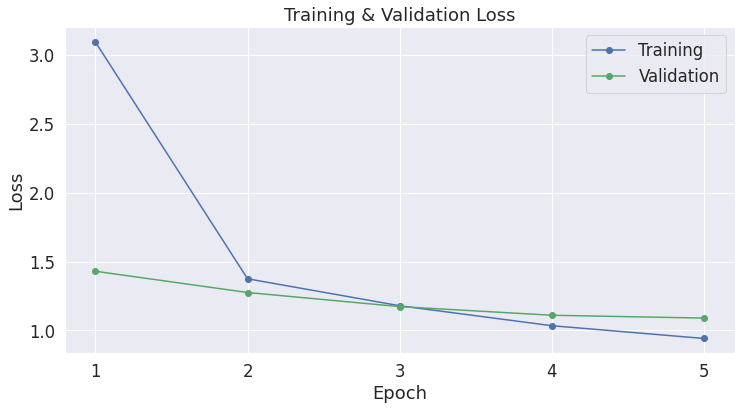

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
xt = [i for i in range(1,epochs+1)]
plt.xticks(xt)

plt.show()

In [ ]:
import os
out_dir = '/TrumpTweet'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained('./')
tokenizer.save_pretrained('./')

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.json',
 './merges.txt',
 './added_tokens.json')

Let's see how well our model performs

In [ ]:
model.eval()

prompt = "<|sos|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=5
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: I am extremely excited about the potential and strength of @Macys. They are doing very well compared to some of the other stocks, but they have had a great first two years and a great chance of going down the tubes. They are a long way from the dead, and a great JOBS plan!


1: The Failing New York Times has written yet another phony and untrue story, this time on the totally partisan Russia Hoax. Written by a disgruntled employee (Mr. Russia) of the same firm, this time using the name of an innocent journalist, the Times has gone absolutely CRAZY. They are truly the Enemy of the People and our Nation itself!


2: Just landed in San Francisco. It was amazing to see the enthusiasm of the visiting Governor, Gavin Newsom. He said I look forward to working together with the Republican Party on Healthcare!


3: I would like to thank you very much for reading the Transcripts, which reveal the total truth. They are a badly written and badly worded document that shows many of the lies of th

In [ ]:
#Load Saved Model

model = GPT2LMHeadModel.from_pretrained('./')
tokenizer = GPT2Tokenizer.from_pretrained('./')
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50260, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

Let's use a tweet from Trump's account from 2012.

In [ ]:
tweet_2012 = 'it makes me feel so good to hit sleazebags back much better than seeing a psychiatrist which i never have'

In [ ]:
model.eval()

prompt = tweet_2012

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=5
                                )
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: it makes me feel so good to hit sleazebags back much better than seeing a psychiatrist which i never have!


1: it makes me feel so good to hit sleazebags back much better than seeing a psychiatrist which i never have! #MAGA


2: it makes me feel so good to hit sleazebags back much better than seeing a psychiatrist which i never have, or any other mental health professional. The “Oversight” must be taken very seriously! https://t.co/n0G6tzJQA


3: it makes me feel so good to hit sleazebags back much better than seeing a psychiatrist which i never have!


4: it makes me feel so good to hit sleazebags back much better than seeing a psychiatrist which i never have. Fake News doesn’t want to admit it, like lonely Brian Williams who bombed so badly with MS 13 that his last name is ‘Gus’. https://t.co/qL8JFnHpnv




We can clearly see how well Transformers performed and generated the tweet accurately

#MODEL EVALUATIONS

MODEL EVALUATIONS:
The following models are considered for sentimental analysis for trumps twitter data:

1.LSTM

2.BILSTM

3.BILSTM with attention

4.GRU MODEL

both trained and pretrained embeddings have been performed for the above models.

Embeddings used:

1.Glove 

2.word2vec 

3.Fast text 

Metrics considered for model evaluation

1. Model accuracy

2. Classification report
    .Precision
    .Recall
    .F-1 score
    .Support
    .macro avg
    .weighted avg
    
3. Performance plot
    .model accuracy
    .model loss



TRAINED MODELS :

1. LSTM without any Pretrained data

Accuracy : 

0.9165057915057915

65/65 [==============================] - 2s 36ms/step

- loss: 0.6982 
- acc: 0.9165

[0.6981731057167053, 0.9165058135986328]

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1764
           1       0.72      0.72      0.72       308

    accuracy                           0.92      2072

   macro avg       0.83      0.84      0.84      2072

weighted avg       0.92      0.92      0.92      2072

2. BILSTM without any pretrained data

Accuracy : 

0.9247104247104247

65/65 [==============================] - 4s 57ms/step 
- loss: 0.3800 

- acc: 0.9247

[0.3800342381000519, 0.9247104525566101]

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1764
           1       0.75      0.74      0.74       308

    accuracy                           0.92      2072

   macro avg       0.85      0.85      0.85      2072

weighted avg       0.92      0.92      0.92      

3. BILSTM attention layer without any pretrained data

Accuracy : 

0.9107142857142857

65/65 [==============================] - 4s 56ms/step

 - loss: 0.3789 

 - acc: 0.9107

[0.3789480924606323, 0.9107142686843872]

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1764
           1       0.74      0.62      0.67       308

    accuracy                           0.91      2072

   macro avg       0.84      0.79      0.81      2072

weighted avg       0.91      0.91      0.91      2072

4.Word2Vec from Scratch

Test Score: 0.4964491128921509
Test Accuracy: 0.91361004114151 

5.Naives Bayes Classification

Model ROC-AUC score for training sample: 0.966

Model ROC-AUC score for test sample: 0.886

Train Accuracy ::  0.9393103448275862

Test Accuracy ::  0.8751608751608752









#Pretrained model model evaluation metrics



**GLOVE EMBEDDING**

LSTM:

Accuracy : 

0.918918918918919

65/65 [==============================] - 2s 35ms/step 

- loss: 0.6493 

- acc: 0.9189

[0.649330735206604, 0.9189189076423645]

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1764
           1       0.72      0.74      0.73       308

    accuracy                           0.92      2072

   macro avg       0.84      0.85      0.84      2072

weighted avg       0.92      0.92      0.92      2072

BILSTM:

Accuracy : 

0.9232625482625483

65/65 [==============================] - 4s 56ms/step

 - loss: 0.6285

 - acc: 0.9233

[0.628511905670166, 0.9232625365257263]

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1764
           1       0.75      0.73      0.74       308

    accuracy                           0.92      2072

   macro avg       0.85      0.84      0.85      2072

weighted avg       0.92      0.92      0.92      2072

BILSTM with attention:

Accuracy : 

0.8904440154440154

65/65 [==============================] - 2s 35ms/step

 - loss: 0.6493

 -  acc: 0.9189

[0.649330735206604, 0.9189189076423645]

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1764
           1       0.62      0.67      0.65       308

    accuracy                           0.89      2072

   macro avg       0.78      0.80      0.79      2072

weighted avg       0.89      0.89      0.89      2072

GRU MODEL

Accuracy : 

0.9251930501930502

65/65 [==============================] - 2s 28ms/step 

- loss: 0.2189 

- acc: 0.9252

[0.21885237097740173, 0.9251930713653564]

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1764
           1       0.73      0.80      0.76       308

    accuracy                           0.93      2072

   macro avg       0.84      0.87      0.86      2072
   
weighted avg       0.93      0.93      0.93      2072



**Word2vec pretrained embedding**

**LSTM**

Accuracy : 

0.9251930501930502

65/65 [==============================] - 6s 88ms/step

 - loss: 0.2308

 - acc: 0.9252

[0.2308078557252884, 0.9251930713653564]

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1764
           1       0.76      0.73      0.74       308

    accuracy                           0.93      2072

   macro avg       0.86      0.84      0.85      2072

weighted avg       0.92      0.93      0.92      2072

BILSTM

Accuracy : 

0.9251930501930502

65/65 [==============================] - 10s 157ms/step 

- loss: 0.3189 

- acc: 0.9252

[0.3188759982585907, 0.9251930713653564]

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1764
           1       0.75      0.74      0.75       308

    accuracy                           0.93      2072

   macro avg       0.85      0.85      0.85      2072

weighted avg       0.92      0.93      0.92      2072

BILSTM with attention

Accuracy : 

0.9025096525096525

65/65 [==============================] - 10s 158ms/step 

- loss: 0.2604 

- acc: 0.9025

[0.2604229748249054, 0.9025096297264099]

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1764
           1       0.70      0.60      0.65       308

    accuracy                           0.90      2072

   macro avg       0.82      0.78      0.80      2072

weighted avg       0.90      0.90      0.90      2072

GRU MODEL

Accuracy : 

0.9333976833976834

65/65 [==============================] - 2s 37ms/step 

- loss: 0.2344

- acc: 0.9334

[0.23435895144939423, 0.9333977103233337]

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1764
           1       0.78      0.78      0.78       308

    accuracy                           0.93      2072

   macro avg       0.87      0.87      0.87      2072
   
weighted avg       0.93      0.93      0.93      2072


-



**FAST TEXT EMBEDDING**

LSTM

Accuracy : 

0.9078185328185329

65/65 [==============================] - 4s 64ms/step

 - loss: 0.2635 

 - acc: 0.9078

[0.2635268270969391, 0.9078185558319092]

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1764
           1       0.69      0.70      0.69       308

    accuracy                           0.91      2072

   macro avg       0.82      0.82      0.82      2072

weighted avg       0.91      0.91      0.91      2072

BILSTM

Accuracy : 

0.8682432432432432

65/65 [==============================] - 7s 109ms/step 

- loss: 0.3031

- acc: 0.8682

[0.3030523359775543, 0.8682432174682617]

              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1764
           1       0.54      0.85      0.66       308

    accuracy                           0.87      2072

   macro avg       0.75      0.86      0.79      2072

weighted avg       0.91      0.87      0.88      2072

BILSTM with attention

Accuracy : 

0.9073359073359073

65/65 [==============================] - 7s 111ms/step 

- loss: 0.2401 

- acc: 0.9073

[0.24010729789733887, 0.9073359370231628]

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1764
           1       0.67      0.75      0.71       308

    accuracy                           0.91      2072

   macro avg       0.81      0.84      0.83      2072

weighted avg       0.91      0.91      0.91      2072

GRU MODEL

Accuracy : 

0.916023166023166

65/65 [==============================] - 3s 38ms/step 

- loss: 0.2151 

- acc: 0.9160

[0.2150605469942093, 0.9160231947898865]

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1764
           1       0.72      0.72      0.72       308

    accuracy                           0.92      2072

   macro avg       0.83      0.83      0.83      2072
   
weighted avg       0.92      0.92      0.92      2072

While comparing each models individual performances GRU Model performed well with all the types of embeddings with around 93% of accuracy.

when compared with pretrained embedding and models together 
both GRU Models and BILSTM performed well with glove embedding when compared with word2vec and fasttext



GRU is related to LSTM as both are utilizing different way if gating information to prevent vanishing gradient problem. Here are some pin-points about GRU vs LSTM-

The GRU controls the flow of information like the LSTM unit, but without having to use a memory unit. It just exposes the full hidden content without any control.
GRU is relatively new, and from my perspective, the performance is on par with LSTM, but computationally more efficient (less complex structure as pointed out). So we are seeing it being used more and more.
From my experience, GRUs train faster and perform better than LSTMs on less training data if you are doing language modeling (not sure about other tasks).

GRUs are simpler and thus easier to modify, for example adding new gates in case of additional input to the network. It's just less code in general.

LSTMs should in theory remember longer sequences than GRUs and outperform them in tasks requiring modeling long-distance relations.




##FINAL THOUGHTS


This answer actually lies on the dataset and the use case. It's hard to tell definitively which is better.

GRU exposes the complete memory unlike LSTM, so applications which that acts as advantage might be helpful. Also, adding onto why to use GRU - it is computationally easier than LSTM since it has only 2 gates and if it's performance is on par with LSTM, then why not?
This paper demonstrates excellently with graphs the superiority of gated networks over a simple RNN but clearly mentions that it cannot conclude which of the either are better. So, if you are confused as to which to use as your model, I'd suggest you to train both and then get the better of them.